# Credits

* **Author** : Aurelio Murolo
* **Student ID** : D03000086
* **Text Mining Course** a.a 2024/2025
* Data Science Master at DIETI, University of Naples Federico 2

# Modules Download & Import

In [ ]:
!pip install -qq faiss-cpu bs4 langchain-core tqdm
!pip install -qq --upgrade langchain langchain-community langchain-openai transformers
!pip install -qq --upgrade langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Web Crawling & Html parsing
import bs4
import requests
from bs4 import BeautifulSoup
import time
import random
import logging
from datetime import datetime
from typing import List, Optional

# Document loaders
from langchain_community.document_loaders import WebBaseLoader
from langchain.schema import Document
from langchain_community.document_loaders.merge import MergedDataLoader
import re
import tqdm

# Text Splitting
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter, TokenTextSplitter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Embedded vectors & Storage
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import faiss
from sentence_transformers import SentenceTransformer
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [ ]:
# RAG
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForQuestionAnswering, pipeline
from langchain import PromptTemplate, LLMChain
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


import textwrap
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Gradio
!pip install -qq --upgrade gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 10.1 MB/s eta 0:00:00


# Project Objective

> Build a RAG chatbot
which answers questions about the most recent news (e.g., all news published
in the month preceding the publishing of your project). It will be
considered a plus if different models or different options in the system architecure
are explored by considering their different impact on performance
and on implementation. In the presentation of the project (no more than
10 slides), you are required to discuss the different modules focusing on the
points considered during the course.

# Usefull Material

1. The information must be retrived from the [**EU  Commission's departments and services**](https://commission.europa.eu/news-and-media/news_en#oe-list-page-filters-anchor)
2. LangChain offers a tutorial to explain how to [**Build a Retrieval Augmented Generation (RAG) App**
](https://python.langchain.com/docs/tutorials/rag/)

In the next cell of code we are going to add the url related the the selected news. Since we want to organize a set of question for each document to test different version of our RAG application, it is crucial to remember the ordering of the documents.

In [ ]:
url_list = ["https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en",
            "https://north-africa-middle-east-gulf.ec.europa.eu/news/eu-pledges-eu23-billion-european-humanitarian-forum-2025-2025-05-20_en",
            "https://north-africa-middle-east-gulf.ec.europa.eu/news/ebrd-eu-gcf-and-canada-promote-green-lending-moroccos-private-sector-2025-05-16_en"]

question_set = []

Since each of such webpages contains also the metadata about the keywords, one may thinks to integrate also a more classical keywords based searching with the Vector DB. One example may be : `<meta name="keywords" content="Middle East" />` for the first document in the above list.

# Collecting Web Page links

The function below has been used to get the links of the news published in the last month.

In [ ]:
def collect_news_data(num_pages = 100, delay_range = (1, 3), max_retries = 3, verbose = True):
    """
    Collects URLs, titles, and dates of news from the European Commission website.
    Optimized version to handle a high number of pages.

    :param num_pages: Number of pages to scan (from 0 to num_pages-1).
    :param delay_range: Tuple (min, max) for random delay between requests in seconds.
    :param max_retries: Maximum number of attempts for each page in case of error.
    :param verbose: If True, shows detailed progress information.
    :return: Pandas DataFrame with columns [link_url, article_title, publication_date] and list of failed pages.
    """

    BASE_URL = 'https://commission.europa.eu/news-and-media/news_en'
    HEADERS = {
        'User-Agent': (
            'Mozilla/5.0 (X11; Linux x86_64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/120.0.0.0 Safari/537.36'
        ),
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }

    # Setup logging if verbose is True
    if verbose:
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        logger = logging.getLogger(__name__)

    articles_data = []  # List of dictionaries with article data
    failed_pages = []

    # Create a session to maintain connections
    session = requests.Session()
    session.headers.update(HEADERS)

    # Progress bar
    progress_bar = tqdm(range(num_pages), desc="Scanning pages") if verbose else range(num_pages)

    for page in progress_bar:
        success = False

        for attempt in range(max_retries):
            try:
                params = {'page': page}
                response = session.get(BASE_URL, params=params, timeout=30)
                response.raise_for_status()

                soup = BeautifulSoup(response.text, 'html.parser')

                # Find all articles on the page
                articles = soup.select('div.ecl-content-item-block article.ecl-content-item')

                page_articles = []
                for article in articles:
                    try:
                        # Extract the link
                        link_element = article.select_one('.ecl-content-block__title a')
                        if not link_element:
                            continue

                        link_url = link_element.get('href', '').strip()
                        if not link_url:
                            continue

                        # Extract the title
                        article_title = link_element.get_text(strip=True)

                        # Extract the publication date
                        date_element = article.select_one('.ecl-content-block__primary-meta-container time')
                        publication_date = ''

                        if date_element:
                            # Try first with datetime attribute
                            datetime_attr = date_element.get('datetime')
                            if datetime_attr:
                                try:
                                    # Convert from ISO format to readable format
                                    dt = datetime.fromisoformat(datetime_attr.replace('Z', '+00:00'))
                                    publication_date = dt.strftime('%Y-%m-%d')
                                except:
                                    # If it fails, use the element text
                                    publication_date = date_element.get_text(strip=True)
                            else:
                                publication_date = date_element.get_text(strip=True)

                        # Add article data
                        article_data = {
                            'link_url': link_url,
                            'article_title': article_title,
                            'publication_date': publication_date
                        }
                        page_articles.append(article_data)

                    except Exception as e:
                        if verbose:
                            logger.warning(f"Error extracting article data on page {page}: {e}")
                        continue

                articles_data.extend(page_articles)
                success = True

                if verbose and page_articles:
                    if hasattr(progress_bar, 'set_postfix'):
                        progress_bar.set_postfix({
                            'Articles found': len(page_articles),
                            'Total': len(articles_data),
                            'Page': page
                        })

                break  # Exit retry loop if successful

            except requests.exceptions.RequestException as e:
                if verbose:
                    logger.warning(f"Attempt {attempt + 1} failed for page {page}: {e}")

                if attempt == max_retries - 1:
                    failed_pages.append(page)
                    if verbose:
                        logger.error(f"Page {page} skipped after {max_retries} attempts")
                else:
                    # Longer delay in case of error
                    time.sleep(random.uniform(delay_range[1], delay_range[1] * 2))

            except Exception as e:
                if verbose:
                    logger.error(f"Unexpected error for page {page}: {e}")
                failed_pages.append(page)
                break

        # Random delay between requests to be respectful to the server
        if success and page < num_pages - 1:  # Don't wait after the last page
            delay = random.uniform(delay_range[0], delay_range[1])
            time.sleep(delay)

    # Close the session
    session.close()

    # Create pandas DataFrame
    df = pd.DataFrame(articles_data)

    # Remove duplicates based on URL (keep first)
    if not df.empty:
        df = df.drop_duplicates(subset=['link_url'], keep='first').reset_index(drop=True)

    # Final report
    if verbose:
        logger.info(f"\n{'='*50}")
        logger.info(f"FINAL REPORT:")
        logger.info(f"Pages scanned: {num_pages}")
        logger.info(f"Failed pages: {len(failed_pages)}")
        logger.info(f"Total articles found: {len(articles_data)}")
        logger.info(f"Unique articles in DataFrame: {len(df)}")

        if failed_pages:
            logger.info(f"Failed pages: {failed_pages[:10]}{'...' if len(failed_pages) > 10 else ''}")

        logger.info(f"{'='*50}")

    return df, failed_pages

def collect_news_data_batch(num_pages=500, batch_size=50, save_intermediate=True, filename_prefix="eu_news", **kwargs):
    """
    Batch version that processes pages in smaller groups.
    Automatically saves intermediate and final results.

    :param num_pages: Total number of pages to scan.
    :param batch_size: Number of pages per batch.
    :param save_intermediate: If True, saves intermediate CSV files for each batch.
    :param filename_prefix: Prefix for saved file names.
    :param kwargs: Other parameters to pass to collect_news_data.
    :return: Final pandas DataFrame and list of failed pages.
    """
    all_articles_data = []
    all_failed_pages = []

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for batch_num, start_page in enumerate(range(0, num_pages, batch_size)):
        end_page = min(start_page + batch_size, num_pages)
        batch_pages = end_page - start_page

        print(f"\n🔄 Processing batch {batch_num + 1}: pages {start_page}-{end_page-1} ({batch_pages} pages)")

        # Process the batch
        batch_df, batch_failed = collect_news_data(
            num_pages=batch_pages,
            **kwargs
        )

        # Add offset to failed pages
        adjusted_failed = [page + start_page for page in batch_failed]
        all_failed_pages.extend(adjusted_failed)

        if not batch_df.empty:
            all_articles_data.append(batch_df)

            # Save intermediate results if requested
            if save_intermediate:
                batch_filename = f"{filename_prefix}_batch_{batch_num + 1}_{timestamp}.csv"
                batch_df.to_csv(batch_filename, index=False, encoding='utf-8')
                print(f"💾 Batch saved: {batch_filename} ({len(batch_df)} articles)")

        print(f"✅ Batch {batch_num + 1} completed: {len(batch_df)} articles found")

        # Longer pause between batches
        if end_page < num_pages:
            print("⏳ Pause between batches...")
            time.sleep(random.uniform(5, 10))

    # Combine all DataFrames
    if all_articles_data:
        final_df = pd.concat(all_articles_data, ignore_index=True)
        # Remove final duplicates
        final_df = final_df.drop_duplicates(subset=['link_url'], keep='first').reset_index(drop=True)
    else:
        final_df = pd.DataFrame(columns=['link_url', 'article_title', 'publication_date'])

    # Save final result
    final_filename = f"{filename_prefix}_final_{timestamp}.csv"
    final_df.to_csv(final_filename, index=False, encoding='utf-8')
    print(f"\n💾 FINAL RESULT SAVED: {final_filename}")
    print(f"📊 Total articles: {len(final_df)}")

    return final_df, all_failed_pages

In [ ]:
start_crawler = False

if start_crawler:
  df_final, failed_pages = collect_news_data_batch(
      num_pages = 100,
      batch_size = 10,
      delay_range = (1, 3),
      max_retries = 3,
      verbose = True,
      save_intermediate = True,
      filename_prefix = "eu_commission_news")

  print(f"✅ Completed! {len(df_final)} articles collected")
  print(f"📁 Final file saved with timestamp")
  print(f"❌ Failed pages: {len(failed_pages)}")

  # Display statistics
  print("\\n📈 STATISTICS:")
  print(f"Articles by date:")
  print(df_final['publication_date'].value_counts().head(10))

else:
  df_urls = pd.read_csv("/content/eu_commission_news_final_20250526_154206.csv")

In [ ]:
df_urls

,link_url,titolo_articolo,data_pubblicazione
0,https://urban-mobility-observatory.transport.e...,UPPER launches two new integrated digital tool...,2025-05-26
1,https://accessible-eu-centre.ec.europa.eu/cont...,Open call for tender for two project team experts,2025-05-26
2,https://european-masters-translation-blog.ec.e...,Confidential? Not at all! Why does your transl...,2025-05-26
3,https://european-masters-translation-blog.ec.e...,Interpreting safari: unlocking the memory of a...,2025-05-26
4,https://energy-efficient-products.ec.europa.eu...,Webinar on 11th June 2025 - New energy labelli...,2025-05-26
...,...,...,...
457,https://policy.trade.ec.europa.eu/news/eu-take...,EU takes action against dumped imports of food...,2025-04-11
458,https://urban-mobility-observatory.transport.e...,Mobility ranking 2025: Karlstad,2025-04-11
459,https://transport.ec.europa.eu/news-events/new...,Commission enhances interoperability and trans...,2025-04-11
460,https://european-union.europa.eu/eu-strikes-de...,EU strikes deal on new toy safety rules to bet...,2025-04-11


In [ ]:
print(f"✅ Completed! {len(df_urls)} articles collected")

✅ Completed! 462 articles collected


# HTML Web Page Parsing with LangChain

In the following i'm going to show how to extract the contents desired from a chosen EU news from the webpage, in my case i'm working with the article : [*Joint donor statement on humanitarian aid to Gaza*](https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en). Althought the code below may be optimized, it is highly readable and it point out how the information are extracted given an url.

In [ ]:
url = "https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en"

# SoupStrainer setup
bs4_strainer_title = bs4.SoupStrainer(class_=("ecl-page-header__title"))
bs4_strainer_content = bs4.SoupStrainer(class_=("ecl"))
bs4_strainer_details = bs4.SoupStrainer(name = 'dd', class_=("ecl-description-list__definition"))

# Title & Content
web_loader_title = WebBaseLoader(web_paths=(url,),
                                bs_kwargs={"parse_only": bs4_strainer_title},)
web_loader_content = WebBaseLoader(web_paths=(url,),
                                  bs_kwargs={"parse_only": bs4_strainer_content},)

# Details(Author & Publication Date)
web_loader_details = WebBaseLoader(web_paths=(url,),
                                  bs_kwargs={"parse_only": bs4_strainer_details},)

# Merging loaders
loader_all = MergedDataLoader(loaders=[web_loader_title, web_loader_content, web_loader_details])
docs = loader_all.load()

# Content & Metadata extraction
details_content = docs[2].page_content
matching = re.match(r'(\d{1,2} [A-Z][a-z]+ \d{4})(.+)', details_content)

if matching:
    date = matching.group(1)
    author = matching.group(2)

metadata = {'source': docs[0].metadata['source'],
            'title':docs[0].page_content,
            'date':date,
            'author':author}

# Langchain Document object
lang_Doc = Document(page_content = docs[1].page_content,
                    metadata = metadata)
for key, value in lang_Doc.metadata.items():
  print(f"{key}: {value}")

print(f"\nDocument content:\n{lang_Doc.page_content[:100]}...")

source: https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en
title: Joint donor statement on humanitarian aid to Gaza
date: 20 May 2025
author: Directorate-General for the Middle East, North Africa and the Gulf

Document content:
Whilst we acknowledge indications of a limited restart of aid, Israel blocked humanitarian aid enter...


## URL to LangChain Document Object

Lets'express the above algorithm as a python function :

In [ ]:
def URL_to_LangChain_Doc(url:str, show_docs:bool = True):
  # SoupStrainer setup
  bs4_strainer_title = bs4.SoupStrainer(class_=("ecl-page-header__title"))
  bs4_strainer_content = bs4.SoupStrainer(class_=("ecl"))
  bs4_strainer_details = bs4.SoupStrainer(name = 'dd', class_=("ecl-description-list__definition"))

  # Title & Content
  web_loader_title = WebBaseLoader(web_paths=(url,),
                                  bs_kwargs={"parse_only": bs4_strainer_title},)
  web_loader_content = WebBaseLoader(web_paths=(url,),
                                    bs_kwargs={"parse_only": bs4_strainer_content},)

  # Details(Author & Publication Date)
  web_loader_details = WebBaseLoader(web_paths=(url,),
                                    bs_kwargs={"parse_only": bs4_strainer_details},)

  # Merging loaders
  loader_all = MergedDataLoader(loaders=[web_loader_title, web_loader_content, web_loader_details])
  docs = loader_all.load()

  # Set defaults
  date = "Unknown"
  author = "Unknown"

  # Content & Metadata extraction
  details_content = docs[2].page_content
  matching = re.match(r'(\d{1,2} [A-Z][a-z]+ \d{4})(.+)', details_content)

  if matching:
    date = matching.group(1)
    author = matching.group(2)

  metadata = {'source': docs[0].metadata['source'],
              'title':docs[0].page_content,
              'date':date,
              'author':author}

  # Langchain Document object
  lang_Doc = Document(page_content = docs[1].page_content,
                      metadata = metadata)

  if show_docs:
    for key, value in lang_Doc.metadata.items():
      print(f"{key}: {value}")

    print(f"\nDocument content:\n{lang_Doc.page_content[:100]}...")

  return lang_Doc

In [ ]:
DOC = URL_to_LangChain_Doc(url)

source: https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en
title: Joint donor statement on humanitarian aid to Gaza
date: 20 May 2025
author: Directorate-General for the Middle East, North Africa and the Gulf

Document content:
Whilst we acknowledge indications of a limited restart of aid, Israel blocked humanitarian aid enter...


The next step is to extend the procedure above for a given set of urls.

In [ ]:
def URL_list_to_LangChain_Doc(url_list:list):
  lang_Doc_list = []
  for url in url_list:
    print(f"\n==== Processing Document {url_list.index(url) + 1} ====\n")
    doc = URL_to_LangChain_Doc(url)
    lang_Doc_list.append(doc)
  return lang_Doc_list

In [ ]:
# Example
Doc_list = URL_list_to_LangChain_Doc(url_list)


==== Processing Document 1 ====

source: https://north-africa-middle-east-gulf.ec.europa.eu/news/joint-donor-statement-humanitarian-aid-gaza-2025-05-20_en
title: Joint donor statement on humanitarian aid to Gaza
date: 20 May 2025
author: Directorate-General for the Middle East, North Africa and the Gulf

Document content:
Whilst we acknowledge indications of a limited restart of aid, Israel blocked humanitarian aid enter...

==== Processing Document 2 ====

source: https://north-africa-middle-east-gulf.ec.europa.eu/news/eu-pledges-eu23-billion-european-humanitarian-forum-2025-2025-05-20_en
title: EU pledges €2.3 billion at European Humanitarian Forum 2025
date: 20 May 2025
author: Directorate-General for the Middle East, North Africa and the Gulf

Document content:
The European Commission announced an initial humanitarian pledge of over €2.3 billion for 2025 to ad...

==== Processing Document 3 ====

source: https://north-africa-middle-east-gulf.ec.europa.eu/news/ebrd-eu-gcf-and-canad

Lets' optimize the code the better handle all the possible failures and the extration of the needed metadata for the news.

> For academic honesty it is necessry to undelrine that both the  cell of code below and the crawler have been obtained using the "home made" funciton above plus a well suited prompt submitted to the **Claude Sonnet AI**, of course this does not mean that we do not understand or control its functionalities. The skills needed to do it by hand are not part of the course.

In [ ]:
def URL_to_LangChain_Doc(url: str, show_docs: bool = True, max_retries: int = 3) -> Optional[Document]:
    """
    Convert a URL to a LangChain Document.
    Enhanced version with better metadata extraction and content validation.
    """

    for attempt in range(max_retries):
        try:
            # Quick check if URL is accessible
            response = requests.head(url, timeout=10)
            if response.status_code >= 400:
                print(f"⚠️ URL not accessible: {url} (Status: {response.status_code})")
                return None

            # SoupStrainer setup - Only for content extraction (meta tags handled separately)
            bs4_strainer_title = bs4.SoupStrainer(class_=("ecl-page-header__title"))
            bs4_strainer_content = bs4.SoupStrainer(class_=("ecl"))
            bs4_strainer_details = bs4.SoupStrainer(name='dd', class_=("ecl-description-list__definition"))

            # Create loaders (only for title, content, and details)
            web_loader_title = WebBaseLoader(web_paths=(url,),
                                           bs_kwargs={"parse_only": bs4_strainer_title})
            web_loader_content = WebBaseLoader(web_paths=(url,),
                                             bs_kwargs={"parse_only": bs4_strainer_content})
            web_loader_details = WebBaseLoader(web_paths=(url,),
                                             bs_kwargs={"parse_only": bs4_strainer_details})

            # Merge loaders (only 3 now)
            loader_all = MergedDataLoader(loaders=[web_loader_title,
                                                   web_loader_content,
                                                   web_loader_details])
            docs = loader_all.load()

            # Check if we have sufficient documents
            if not docs or len(docs) < 3:
                print(f"⚠️ Insufficient documents for URL: {url} (got {len(docs) if docs else 0})")
                return None

            # CRITICAL CHECK: Validate main content exists
            main_content = docs[1].page_content if len(docs) > 1 and docs[1].page_content else ""
            if not main_content or len(main_content.strip()) < 50:  # Minimum content threshold
                print(f"⚠️ Insufficient content extracted from URL: {url}")
                return None

            # Set defaults
            date = "Unknown"
            author = "Unknown"

            # Content & Metadata extraction - more robust version
            details_content = docs[2].page_content if len(docs) > 2 and docs[2].page_content else ""

            # Enhanced date and author extraction
            if details_content:
                # Try original pattern
                matching = re.match(r'(\d{1,2} [A-Z][a-z]+ \d{4})(.+)', details_content)
                if matching:
                    date = matching.group(1)
                    author = matching.group(2).strip()
                else:
                    # Alternative patterns
                    date_patterns = [
                        r'(\d{1,2}/\d{1,2}/\d{4})',      # "15/12/2023"
                        r'(\d{4}-\d{2}-\d{2})',          # "2023-12-15"
                        r'([A-Z][a-z]+ \d{1,2}, \d{4})', # "December 15, 2023"
                    ]

                    for pattern in date_patterns:
                        match = re.search(pattern, details_content)
                        if match:
                            date = match.group(1)
                            remaining = details_content[match.end():].strip()
                            if remaining:
                                author = remaining[:100]
                            break

            # FIXED: Extract keywords and description directly with requests + BeautifulSoup
            # LangChain WebBaseLoader fails on these EU sites, so we bypass it
            keywords = "Unknown Keywords"
            description = "Unknown Description"

            try:
                # Get the full HTML directly
                response = requests.get(url, timeout=10)
                if response.status_code == 200:
                    # Parse with BeautifulSoup
                    soup = bs4.BeautifulSoup(response.text, 'html.parser')

                    # Extract keywords
                    meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
                    if meta_keywords and meta_keywords.get('content'):
                        keywords = meta_keywords.get('content').strip()

                    # Extract description
                    meta_description = soup.find('meta', attrs={'name': 'description'})
                    if meta_description and meta_description.get('content'):
                        description = meta_description.get('content').strip()

            except Exception as meta_error:
                print(f"⚠️ Meta extraction failed for {url}: {meta_error}")
                # Keep default values

            # Metadata
            metadata = {
                'source': docs[0].metadata['source'] if docs[0].metadata else url,
                'title': docs[0].page_content if docs[0].page_content else "Unknown Title",
                'date': date,
                'author': author,
                'keywords': keywords,
                'description': description
            }

            # Create LangChain Document object
            lang_Doc = Document(
                page_content=main_content,
                metadata=metadata
            )

            if show_docs:
                print(f"\n{'='*50}")
                for key, value in lang_Doc.metadata.items():
                    print(f"{key}: {value}")
                print(f"\nDocument content length: {len(lang_Doc.page_content)} characters")
                print(f"Content preview:\n{lang_Doc.page_content[:200]}...")
                print(f"{'='*50}")

            return lang_Doc

        except requests.exceptions.RequestException as e:
            print(f"❌ Attempt {attempt + 1} failed for {url}: {e}")
            if attempt < max_retries - 1:
                time.sleep(random.uniform(2, 4))
            else:
                print(f"❌ URL failed after {max_retries} attempts: {url}")
                return None

        except Exception as e:
            print(f"❌ Unexpected error for {url}: {e}")
            return None

    return None


def URL_list_to_LangChain_Doc(url_list: List[str], delay_range: tuple = (1, 3),
                             save_progress: bool = False) -> List[Document]:
    """
    Convert a list of URLs to LangChain Documents.
    Enhanced version with progress tracking and optional saving.
    """
    lang_Doc_list = []
    failed_urls = []
    skipped_urls = []  # URLs that were accessible but had insufficient content

    print(f"🚀 Starting processing of {len(url_list)} URLs")
    print("=" * 50)

    for i, url in enumerate(url_list):
        print(f"\n==== Processing Document {i + 1}/{len(url_list)} ====")
        print(f"URL: {url}")

        doc = URL_to_LangChain_Doc(url, show_docs=False)

        if doc:
            lang_Doc_list.append(doc)
            print(f"✅ Success! Title: {doc.metadata['title'][:50]}...")
        else:
            failed_urls.append(url)
            print(f"❌ Failed or insufficient content")

        # Intermediate save every 10 documents
        if save_progress and len(lang_Doc_list) % 10 == 0 and len(lang_Doc_list) > 0:
            save_intermediate_results(lang_Doc_list, f"intermediate_{len(lang_Doc_list)}")

        # Pause between requests (respect the server)
        if i < len(url_list) - 1:
            delay = random.uniform(delay_range[0], delay_range[1])
            print(f"⏳ Pausing for {delay:.1f} seconds...")
            time.sleep(delay)

    # Final report
    print(f"\n{'='*60}")
    print(f"📊 FINAL REPORT:")
    print(f"✅ Documents processed successfully: {len(lang_Doc_list)}")
    print(f"❌ URLs failed: {len(failed_urls)}")
    print(f"📈 Success rate: {(len(lang_Doc_list)/len(url_list))*100:.1f}%")

    if failed_urls:
        print(f"\n❌ Failed URLs:")
        for url in failed_urls[:5]:
            print(f"   - {url}")
        if len(failed_urls) > 5:
            print(f"   ... and {len(failed_urls) - 5} more")

    print(f"{'='*60}")

    return lang_Doc_list


def create_dataset_from_documents(docs: List[Document], filename: str = None) -> pd.DataFrame:
    """
    Create a pandas DataFrame from LangChain Documents.
    This allows you to work with the data without re-running the extraction.
    """
    if not docs:
        print("❌ No documents provided")
        return pd.DataFrame()

    # Extract data for DataFrame
    data = []
    for doc in docs:
        row = {
            'source': doc.metadata.get('source', ''),
            'title': doc.metadata.get('title', ''),
            'date': doc.metadata.get('date', ''),
            'author': doc.metadata.get('author', ''),
            'keywords': doc.metadata.get('keywords', ''),
            'description': doc.metadata.get('description', ''),
            'content': doc.page_content
        }
        data.append(row)

    df = pd.DataFrame(data)

    # Save to CSV if filename provided
    if filename:
        if not filename.endswith('.csv'):
            filename += '.csv'
        df.to_csv(filename, index=False, encoding='utf-8')
        print(f"💾 Dataset saved to: {filename}")

    print(f"📊 Dataset created with {len(df)} rows and {len(df.columns)} columns")
    print(f"Columns: {list(df.columns)}")

    return df


def load_dataset_from_csv(filename: str) -> pd.DataFrame:
    """
    Load dataset from CSV file.
    """
    try:
        df = pd.read_csv(filename, encoding='utf-8')
        print(f"📂 Loaded dataset with {len(df)} rows from {filename}")
        return df
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return pd.DataFrame()


def dataset_to_documents(df: pd.DataFrame) -> List[Document]:
    """
    Convert DataFrame back to LangChain Documents if needed.
    """
    docs = []
    for _, row in df.iterrows():
        metadata = {
            'source': row.get('source', ''),
            'title': row.get('title', ''),
            'date': row.get('date', ''),
            'author': row.get('author', ''),
            'keywords': row.get('keywords', ''),
            'description': row.get('description', '')
        }
        doc = Document(
            page_content=row.get('content', ''),
            metadata=metadata
        )
        docs.append(doc)

    print(f"📄 Converted {len(docs)} DataFrame rows to LangChain Documents")
    return docs


def save_intermediate_results(docs: List[Document], filename_suffix: str = ""):
    """
    Save intermediate results in simple format.
    """
    import json
    from datetime import datetime

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"docs_backup_{filename_suffix}_{timestamp}.json"

    # Convert to serializable format
    docs_data = []
    for doc in docs:
        docs_data.append({
            'page_content': doc.page_content,
            'metadata': doc.metadata
        })

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(docs_data, f, ensure_ascii=False, indent=2)

    print(f"💾 Backup saved: {filename} ({len(docs)} documents)")


def load_intermediate_results(filename: str) -> List[Document]:
    """
    Load intermediate results from JSON file.
    """
    import json

    with open(filename, 'r', encoding='utf-8') as f:
        docs_data = json.load(f)

    docs = []
    for doc_data in docs_data:
        doc = Document(
            page_content=doc_data['page_content'],
            metadata=doc_data['metadata']
        )
        docs.append(doc)

    print(f"📂 Loaded {len(docs)} documents from {filename}")
    return docs


def test_single_url(url: str):
    """
    Test a single URL to see if extraction works.
    """
    print(f"🧪 Testing URL: {url}")
    doc = URL_to_LangChain_Doc(url, show_docs=True)

    if doc:
        print("✅ Test successful!")
        return True
    else:
        print("❌ Test failed!")
        return False


# Quick test function to verify meta extraction fix
def test_meta_extraction_fix(url: str):
    """
    Quick test to verify that the meta extraction fix works.
    """
    print(f"🧪 Testing meta extraction fix for: {url}")

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = bs4.BeautifulSoup(response.text, 'html.parser')

            # Extract keywords
            meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
            keywords = meta_keywords.get('content').strip() if meta_keywords and meta_keywords.get('content') else "Not found"

            # Extract description
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description = meta_description.get('content').strip() if meta_description and meta_description.get('content') else "Not found"

            print(f"✅ Keywords: {keywords}")
            print(f"✅ Description: {description}")

            return keywords != "Not found" and description != "Not found"
        else:
            print(f"❌ HTTP {response.status_code}")
            return False

    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# Test the fix on one of your URLs
test_url = "https://employment-social-affairs.ec.europa.eu/news/european-labour-authority-supports-fair-labour-mobility-eu-2025-05-26_en"
test_meta_extraction_fix(test_url)

🧪 Testing meta extraction fix for: https://employment-social-affairs.ec.europa.eu/news/european-labour-authority-supports-fair-labour-mobility-eu-2025-05-26_en
✅ Keywords: employment policy, social partners, labour law, labour market
✅ Description: The European Labour Authority (ELA) plays a pivotal role in fair labour mobility within the EU, according to the first Commission evaluation of ELA’s five years of activity.


True

Once we retrived all the urls, we just extract the list from the dataset . It will be our source to create the langchain documents object.

In [ ]:
url_long_list = df_urls["link_url"].to_list()

In [ ]:
content_extraction = False
if content_extraction:
  # Step 1: Extract documents from URLs
  print(f"Step 1: Extracting {len(url_long_list)} documents from URLs...")
  documents = URL_list_to_LangChain_Doc(url_long_list)

  # Step 2: Create dataset and save it
  if documents:
    print("\nStep 2: Creating dataset...")
    df_extracted_doc = create_dataset_from_documents(documents, "extracted_documents")

    # Step 3: Show dataset info
    print("\nStep 3: Dataset preview:")
    print(df_extracted_doc.head())
    print(f"\nDataset shape: {df_extracted_doc.shape}")

In [ ]:
df_extracted_doc = load_dataset_from_csv("extracted_documents.csv")

# Example: Convert back to documents if needed
Doc_list = dataset_to_documents(df_extracted_doc)

📂 Loaded dataset with 296 rows from extracted_documents.csv
📄 Converted 296 DataFrame rows to LangChain Documents


In [ ]:
df_extracted_doc.head(3)

,source,title,date,author,keywords,description,content
0,https://urban-mobility-observatory.transport.e...,UPPER launches two new integrated digital tool...,Unknown,Unknown,"transport research, transport statistics, sust...",The UPPER project launches U-KNOW and U-TRANSF...,"The UPPER project, funded by the Horizon Europ..."
1,https://accessible-eu-centre.ec.europa.eu/cont...,Open call for tender for two project team experts,26 May 2025,UNE,inclusion,Experts will contribute to the drafting of a n...,PT Expert 1 will have expertise in the field o...
2,https://european-masters-translation-blog.ec.e...,Confidential? Not at all! Why does your transl...,26 May 2025,Directorate-General for Translation,translation,"By Meryem Murat, student studying for a Master...",Have you ever wondered where exactly your tran...


In [ ]:
for doc in Doc_list[:3]:
  print(f"\n{'='*50}")
  print(f"\nDocument content length: {len(doc.page_content)} characters")
  print(f"Content preview:{doc.page_content[:50]}...")
  for key, value in doc.metadata.items():
    print(f"{key}: {value}")



Document content length: 2011 characters
Content preview:The UPPER project, funded by the Horizon Europe pr...
source: https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/upper-launches-two-new-integrated-digital-tools-foster-sustainable-mobility-knowledge-exchange-2025-05-26_en
title: UPPER launches two new integrated digital tools to foster sustainable mobility knowledge exchange 
date: Unknown
author: Unknown
keywords: transport research, transport statistics, sustainable mobility, road transport, multimodal transport, urban transport
description: The UPPER project launches U-KNOW and U-TRANSFER to help cities improve public transport through knowledge learning and practical tools.


Document content length: 2171 characters
Content preview:PT Expert 1 will have expertise in the field of ac...
source: https://accessible-eu-centre.ec.europa.eu/content-corner/news/open-call-tender-two-project-team-experts-2025-05-26_en
title: Open call for tender for two projec

In [ ]:
df_extracted_doc.head()

,source,title,date,author,keywords,description,content
0,https://urban-mobility-observatory.transport.e...,UPPER launches two new integrated digital tool...,Unknown,Unknown,"transport research, transport statistics, sust...",The UPPER project launches U-KNOW and U-TRANSF...,"The UPPER project, funded by the Horizon Europ..."
1,https://accessible-eu-centre.ec.europa.eu/cont...,Open call for tender for two project team experts,26 May 2025,UNE,inclusion,Experts will contribute to the drafting of a n...,PT Expert 1 will have expertise in the field o...
2,https://european-masters-translation-blog.ec.e...,Confidential? Not at all! Why does your transl...,26 May 2025,Directorate-General for Translation,translation,"By Meryem Murat, student studying for a Master...",Have you ever wondered where exactly your tran...
3,https://european-masters-translation-blog.ec.e...,Interpreting safari: unlocking the memory of a...,26 May 2025,Directorate-General for Translation,translation,"By Mariia Morenova, student studying for a Mas...",My introduction to the world of interpreting t...
4,https://european-masters-translation-blog.ec.e...,From data to discrimination: when words carry ...,26 May 2025,Directorate-General for Translation,translation,"By Meryem Murat, Ambre Desforges and Raphaëlle...",In a world where international communication a...


It is worth to underline that the **description** metadata can be considered a kind of summary of the processed news, while the **keywords** might be usefull for topic detection.

# Text EDA & Splitting

## EDA

In order to properly select the `chunk_size` parameter for the `RecursiveTextSplitting`, it is important to understand what happens under the hood. The idea is to split each document "manually" using the separators used for the recursive text splitting to get an idea of how much a separator contributes in the splitting phase.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

From the plots we can learn something quite predictable. Since we collected our documents from the web, it easy easy to understand that their structure(especially the organization in paragraphs of a news) is expressed with the HTML markup language insted of these separators. On the other hand it is evident that the word level separator will be the most significant one in the splitting phase.

For a complete overview there is also the plot of the documents lenght.


=== Full Dataset Statistics ===
Sample size: 296
Mean length: 3281
Std length: 2983
Min length: 211
Max length: 32181
Percentiles (25, 50, 75, 90, 95): [1706, 2500, 3984, 6091, 7806]
Mode: 2296 (appears 3 times)

=== First 3 Quartiles (≤ 3984) Statistics ===
Sample size: 222
Mean length: 2141
Std length: 853
Min length: 211
Max length: 3962
Percentiles (25, 50, 75, 90, 95): [1500, 2154, 2801, 3327, 3545]
Mode: 2296 (appears 3 times)


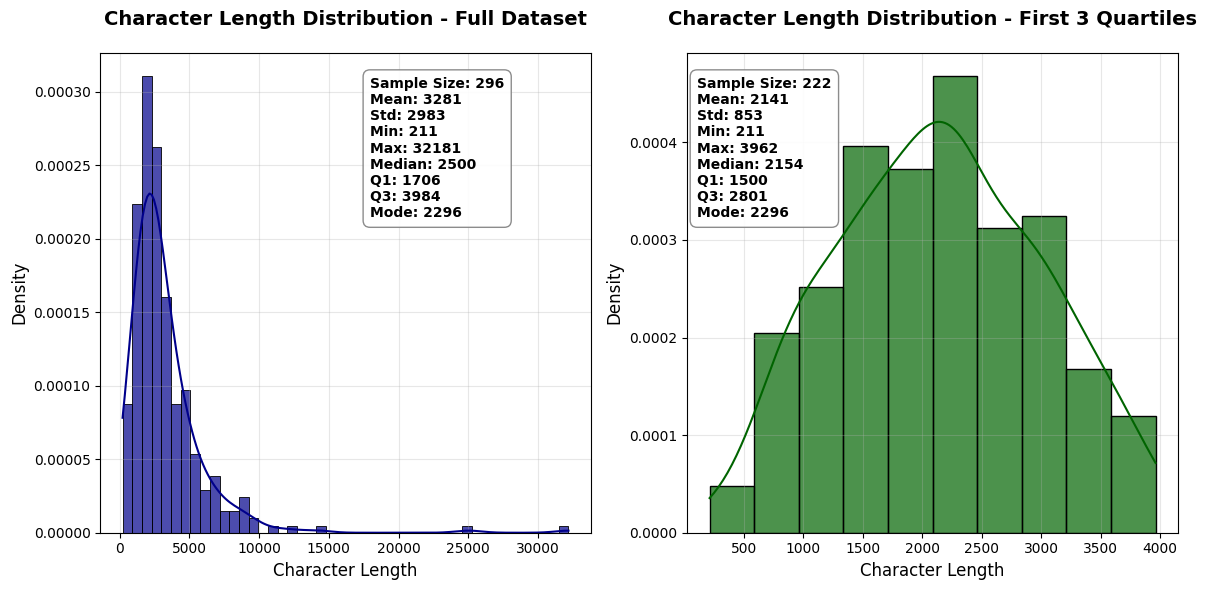

In [ ]:
def analyze_char_lengths(doc_list, quartile_filter=3, bins=None, show_plot=True):
    """
    Analyze and visualize character length distribution of documents.

    Parameters:
    -----------
    doc_list : list
        List of document objects with page_content attribute
    quartile_filter : int, default=3
        Filter data up to this quartile (1, 2, 3, or 4 for no filter)
    bins : int, optional
        Number of bins for histograms. If None, will be calculated automatically
    show_plot : bool, default=True
        Whether to display the visualization

    Returns:
    --------
    dict : Dictionary containing analysis results
    """

    # Calculate character lengths
    char_lengths = [len(doc.page_content) for doc in doc_list]

    # Calculate quartiles for filtering
    quartiles = np.percentile(char_lengths, [25, 50, 75])
    quartile_values = {1: quartiles[0], 2: quartiles[1], 3: quartiles[2]}

    # Prepare data for analysis
    full_data = char_lengths
    if quartile_filter < 4:
        filtered_data = [char for char in char_lengths if char <= quartile_values[quartile_filter]]
        quartile_label = f"Q{quartile_filter}"
    else:
        filtered_data = char_lengths
        quartile_label = "Full Dataset"

    def calculate_stats(data, label):
        """Calculate comprehensive statistics for given data."""
        mean_length = np.mean(data)
        std_length = np.std(data)
        min_length = np.min(data)
        max_length = np.max(data)
        percentiles = np.percentile(data, [25, 50, 75, 90, 95])
        mode_result = stats.mode(data, keepdims=True)

        stats_dict = {
            'data': data,
            'mean': mean_length,
            'std': std_length,
            'min': min_length,
            'max': max_length,
            'percentiles': percentiles,
            'mode': mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan,
            'mode_count': mode_result.count[0] if len(mode_result.count) > 0 else 0
        }

        print(f"\n=== {label} Statistics ===")
        print(f"Sample size: {len(data)}")
        print(f"Mean length: {round(mean_length)}")
        print(f"Std length: {round(std_length)}")
        print(f"Min length: {int(min_length)}")
        print(f"Max length: {int(max_length)}")
        print(f"Percentiles (25, 50, 75, 90, 95): {[int(p) for p in percentiles]}")
        print(f"Mode: {int(stats_dict['mode'])} (appears {stats_dict['mode_count']} times)")

        return stats_dict

    # Calculate statistics
    full_stats = calculate_stats(full_data, "Full Dataset")

    if quartile_filter < 4:
        filtered_stats = calculate_stats(filtered_data, f"First {quartile_filter} Quartiles (≤ {int(quartile_values[quartile_filter])})")
    else:
        filtered_stats = full_stats

    # Create visualization
    if show_plot:
        # Determine number of subplots
        n_plots = 2 if quartile_filter < 4 else 1
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6))

        if n_plots == 1:
            axes = [axes]

        def create_histogram(data, stats_dict, ax, title, color='skyblue', is_first_plot=True):
            """Create enhanced histogram with statistics."""
            # Determine number of bins
            if bins is None:
                q75, q25 = np.percentile(data, [75, 25])
                iqr = q75 - q25
                if iqr > 0:
                    bin_width = 2 * iqr / (len(data) ** (1/3))
                    num_bins = max(10, min(50, int((max(data) - min(data)) / bin_width)))
                else:
                    num_bins = max(10, min(30, int(np.sqrt(len(data)))))
            else:
                num_bins = bins

            # Create histogram
            sns.histplot(data, kde=True, stat="density", bins=num_bins,
                        color=color, alpha=0.7, ax=ax)

            # Vertical lines removed for cleaner visualization

            # Create statistics text box
            stats_text = (
                f"Sample Size: {len(data)}\n"
                f"Mean: {stats_dict['mean']:.0f}\n"
                f"Std: {stats_dict['std']:.0f}\n"
                f"Min: {int(stats_dict['min'])}\n"
                f"Max: {int(stats_dict['max'])}\n"
                f"Median: {int(stats_dict['percentiles'][1])}\n"
                f"Q1: {int(stats_dict['percentiles'][0])}\n"
                f"Q3: {int(stats_dict['percentiles'][2])}\n"
                f"Mode: {int(stats_dict['mode'])}"
            )

            # Position legend separately for each plot
            if is_first_plot:
                # For first plot (full dataset), position on the right
                position_x = 0.55
            else:
                # For second plot (filtered dataset), use dynamic positioning
                position_x = 0.02 if max(data) - min(data) > stats_dict['mean'] else 0.55

            ax.text(position_x, 0.95, stats_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                   alpha=0.9, edgecolor='gray', linewidth=1))

            # Set title and labels
            ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Character Length', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.grid(True, alpha=0.3)
            # Legend removed since statistics are now in the text box

        # Create plots with different colors and legend positioning
        create_histogram(full_data, full_stats, axes[0],
                        'Character Length Distribution - Full Dataset', 'darkblue', is_first_plot=True)

        if quartile_filter < 4:
            create_histogram(filtered_data, filtered_stats, axes[1],
                            f'Character Length Distribution - First {quartile_filter} Quartiles', 'darkgreen', is_first_plot=False)

        plt.tight_layout()
        plt.show()

    # Return results
    results = {
        'full_dataset': full_stats,
        'quartile_info': {
            'filter_level': quartile_filter,
            'quartile_values': quartile_values
        }
    }

    if quartile_filter < 4:
        results['filtered_dataset'] = filtered_stats

    return results

# Example usage:
results = analyze_char_lengths(Doc_list, quartile_filter=3, show_plot=True)

Lets' show the main topic of the last month using a wordcloud plot based on the extracted keywords.

In [ ]:
from wordcloud import WordCloud
def topic_extraction_wordcloud(documents_list:list, show_plot:bool = True):
  list_of_keywords = []
  for doc in documents_list:
    list_of_keywords += doc.metadata['keywords'].split(',')

  # Join the list of words into a single string
  filtered_list_of_keywords = [word.strip() for word in list_of_keywords if word.strip() != 'Unknown Keywords']
  text = ' '.join(filtered_list_of_keywords)

  # Create a WordCloud object
  wordcloud = WordCloud(width=800,
                        height=400,
                        background_color='white',
                        max_words = 30,
                        stopwords = {'Unknown Keywords'},
                        min_font_size = 8).generate(text)

  if show_plot:
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Topic of the moment")
    plt.show()

  return list_of_keywords

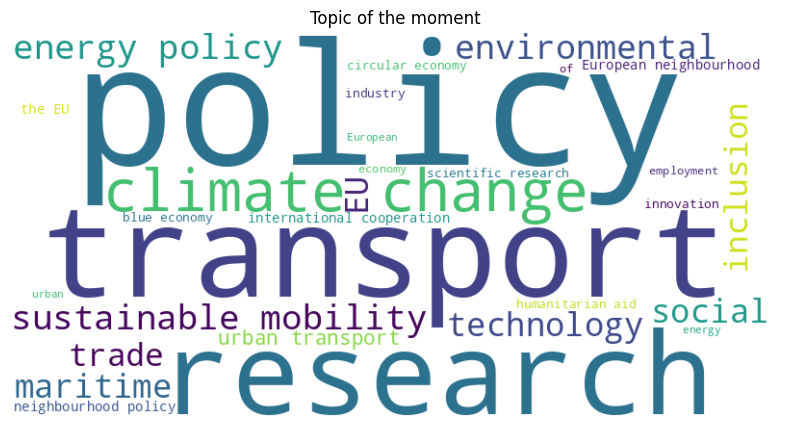

In [ ]:
doc_keywords = topic_extraction_wordcloud(Doc_list, show_plot = True)

In conclusion we saw that the default separator list (when using through LangChain) is:

* "\n\n" (double newline)
* "\n" (single newline)
* " " (space)
* "." (empty string)

This prioritizes keeping paragraphs together (double newline), then sentences (single newline), followed by words (space), and lastly avoids unnecessary splits due to empty strings. Now, based on the distribution plotted above and their statistics,  we can conclude that :
* The splitter which affect the most how the text is splitted is the "space", the double new line and the single new line are not used to give a structure to the text since html, as a markup language, provides other functionalities to do so.

* The distribution of charachter lenghts gives some guidelines to properly select both the chunk size and the chunk overlap, in particular, if one consider only the first 75% of the distribution, we can set a chunk size of 500, 1000, 1500 with a 25% of overlap.

* Percentiles(25, 50, 75, 90, 95): [1706, 2500, 3984, 6091, 7806]
* Percentiles(25, 50, 75, 90, 95): [1500, 2154, 2801, 3327, 3545]
Comment what we should exprecy from the splitting phase based one thsew results. For example the number of expected split for each document base on chunk sieze and overlap and the percentiles.

## Text Splitting

In general, because of both documents lenght and its variability, one should split the text to organize it in **chunk** before computing and storing the embeddings. We can easly apply the `langchain_text_splitters` [API](https://api.python.langchain.com/en/latest/text_splitters_api_reference.html#module-langchain_text_splitters.base).

In [ ]:
Rec_Char_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                                   chunk_overlap=500//4,
                                                   separators  =["\n\n", "\n", " ", ""])

The `.split_documents(Doc_list)` method is well suited to manage a list of Document object, in fact it splits the content of each document without loosing the matching with the relative metadata. It is also important to explore alternative choices for the `chunk_size` and `chunk_overlap` parameters.

In [ ]:
# Example
Rec_CharDoc_splits = Rec_Char_splitter.split_documents(Doc_list)

In [ ]:
for split in Rec_CharDoc_splits[:3]:
 print(f"\n==== Split {Rec_CharDoc_splits.index(split) + 1} ====")
 print(f"\nSplit content:\n{split.page_content[:100]}...\n")

 for key, value in split.metadata.items():
  print(f"{key}: {value}")

print(f"\nNumber of documents: {len(Doc_list)}\nNumber of splits: {len(Rec_CharDoc_splits)}")


==== Split 1 ====

Split content:
The UPPER project, funded by the Horizon Europe programme, has introduced a new digital platform des...

source: https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/upper-launches-two-new-integrated-digital-tools-foster-sustainable-mobility-knowledge-exchange-2025-05-26_en
title: UPPER launches two new integrated digital tools to foster sustainable mobility knowledge exchange 
date: Unknown
author: Unknown
keywords: transport research, transport statistics, sustainable mobility, road transport, multimodal transport, urban transport
description: The UPPER project launches U-KNOW and U-TRANSFER to help cities improve public transport through knowledge learning and practical tools.

==== Split 2 ====

Split content:
in improving public transport systems through better access to information and practical tools.U-KNO...

source: https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/upper-launches-two-new-integrat

In [ ]:
def analyze_optimal_chunking(doc_list, chunk_sizes = [250, 350,  500, 750, 1000],
                           overlap_ratio = 0.25, separators = ["\n\n", "\n", " ", ""],
                           show_plot=True, bins=None, return_dataframe=True):
    """
    Analyze different chunk sizes to find the optimal one for text standardization.

    Parameters:
    -----------
    doc_list : list
        List of document objects with page_content attribute
    chunk_sizes : list, default=[250, 500, 750, 1000]
        List of chunk sizes to test
    overlap_ratio : float, default=0.25
        Overlap ratio (25% overlap)
    separators : list, default=["\n\n", "\n", " ", ""]
        Separators for RecursiveCharacterTextSplitter
    show_plot : bool, default=True
        Whether to display the visualization
    bins : int, optional
        Number of bins for histograms
    return_dataframe : bool, default=True
        Whether to return results as pandas DataFrame

    Returns:
    --------
    dict : Analysis results with recommendations and DataFrame summary
    """

    results = {}
    all_stats = {}

    print("=" * 80)
    print("OPTIMAL CHUNK SIZE ANALYSIS")
    print("=" * 80)
    print(f"Testing chunk sizes: {chunk_sizes}")
    print(f"Overlap ratio: {overlap_ratio * 100}%")
    print(f"Separators: {separators}")
    print("\n")

    # Test each chunk size
    for chunk_size in chunk_sizes:
        chunk_overlap = int(chunk_size * overlap_ratio)

        print(f"🔍 Testing chunk_size={chunk_size}, chunk_overlap={chunk_overlap}")

        # Create splitter
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            separators=separators
        )

        # Split documents
        splits = splitter.split_documents(doc_list)
        split_lengths = np.array([len(split.page_content) for split in splits])

        # Calculate comprehensive statistics
        stats_dict = calculate_chunking_stats(split_lengths, chunk_size)
        all_stats[chunk_size] = stats_dict

        # Store results
        results[chunk_size] = {
            'splits': splits,
            'lengths': split_lengths,
            'stats': stats_dict
        }

    # Determine optimal chunk size
    optimal_chunk_size = determine_optimal_chunk_size(all_stats)

    # Create visualization
    if show_plot:
        create_chunking_comparison_plot(results, bins, optimal_chunk_size)

    # Print recommendations
    print_recommendations(all_stats, optimal_chunk_size)

    # Create DataFrame summary
    df_summary = None
    if return_dataframe:
        df_summary = create_results_dataframe(all_stats, optimal_chunk_size)
        print("\n" + "=" * 80)
        print("📊 PANDAS DATAFRAME SUMMARY")
        print("=" * 80)
        print(df_summary.to_string())

    return {
        'results': results,
        'optimal_chunk_size': optimal_chunk_size,
        'all_stats': all_stats,
        'df_summary': df_summary
    }

def create_results_dataframe(all_stats, optimal_chunk_size):
    """Create a comprehensive pandas DataFrame summary of results."""

    # Prepare data for DataFrame
    df_data = []

    for chunk_size, stats in all_stats.items():
        row = {
            'Chunk_Size': chunk_size,
            'Chunk_Count': stats['count'],
            'Mean_Length': round(stats['mean'], 1),
            'Std_Deviation': round(stats['std'], 1),
            'Median_Q50': round(stats['percentiles'][1], 1),
            'Mode': stats['mode'] if not np.isnan(stats['mode']) else 'N/A',
            'Mode_Count': stats['mode_count'],
            'CV': round(stats['cv'], 4),
            'Target_Achievement': round(stats['target_achievement'], 3),
            'Near_Target_Ratio': round(stats['near_target_ratio'], 3),
            'Uniformity_Score': round(stats['uniformity_score'], 4),
            'Rank': None  # Will be filled below
        }
        df_data.append(row)

    # Create DataFrame
    df = pd.DataFrame(df_data)

    # Sort by uniformity score and add rank
    df = df.sort_values('Uniformity_Score').reset_index(drop=True)
    df['Rank'] = range(1, len(df) + 1)

    # Reorder columns for better readability
    column_order = [
        'Rank', 'Chunk_Size', 'Uniformity_Score',
        'CV', 'Target_Achievement', 'Near_Target_Ratio',
        'Chunk_Count', 'Mean_Length', 'Std_Deviation',
         'Median_Q50', 'Mode', 'Mode_Count'
    ]

    df = df[column_order]

    return df

def get_detailed_dataframe(analysis_results):
    """
    Extract detailed DataFrame with individual chunk lengths for each chunk size.

    Parameters:
    -----------
    analysis_results : dict
        Results from analyze_optimal_chunking function

    Returns:
    --------
    pd.DataFrame : Detailed DataFrame with all chunk lengths
    """

    detailed_data = []

    for chunk_size, result_data in analysis_results['results'].items():
        lengths = result_data['lengths']

        for i, length in enumerate(lengths):
            detailed_data.append({
                'Chunk_Size': chunk_size,
                'Chunk_Index': i,
                'Length': length,
                'Is_Optimal_Size': chunk_size == analysis_results['optimal_chunk_size']
            })

    detailed_df = pd.DataFrame(detailed_data)
    return detailed_df

def calculate_chunking_stats(split_lengths, target_chunk_size):
    """Calculate comprehensive statistics for chunk analysis."""

    # Basic statistics
    mean_length = np.mean(split_lengths)
    std_length = np.std(split_lengths)
    min_length = np.min(split_lengths)
    max_length = np.max(split_lengths)
    percentiles = np.percentile(split_lengths, [25, 50, 75, 90, 95])
    mode_result = stats.mode(split_lengths, keepdims=True)

    # Standardization metrics
    cv = std_length / mean_length if mean_length > 0 else float('inf')  # Coefficient of variation

    # Efficiency metrics
    near_target_ratio = np.sum((split_lengths >= target_chunk_size * 0.8) &
                              (split_lengths <= target_chunk_size * 1.0)) / len(split_lengths)

    # Target achievement
    target_achievement = mean_length / target_chunk_size

    # Uniformity score (lower is better)
    uniformity_score = cv + abs(1 - target_achievement)

    stats_dict = {
        'count': len(split_lengths),
        'mean': mean_length,
        'std': std_length,
        'min': min_length,
        'max': max_length,
        'percentiles': percentiles,
        'mode': mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan,
        'mode_count': mode_result.count[0] if len(mode_result.count) > 0 else 0,
        'cv': cv,
        'near_target_ratio': near_target_ratio,
        'target_achievement': target_achievement,
        'uniformity_score': uniformity_score
    }

    print(f"   📊 Splits created: {stats_dict['count']}")
    print(f"   📏 Mean length: {stats_dict['mean']:.0f} (target: {target_chunk_size})")
    print(f"   📈 Std deviation: {stats_dict['std']:.0f}")
    print(f"   🎯 Target achievement: {stats_dict['target_achievement']:.2f}")
    print(f"   📊 Coefficient of variation: {stats_dict['cv']:.3f}")
    print(f"   ✅ Near-target ratio (80-100%): {stats_dict['near_target_ratio']:.1%}")
    print(f"   🏆 Uniformity score: {stats_dict['uniformity_score']:.3f} (lower=better)")
    print()

    return stats_dict

def determine_optimal_chunk_size(all_stats):
    """Determine optimal chunk size based on uniformity and target achievement."""

    scores = {}
    for chunk_size, stats in all_stats.items():
        # Scoring criteria (lower is better for all)
        scores[chunk_size] = {
            'uniformity_score': stats['uniformity_score'],
            'cv': stats['cv'],
            'target_deviation': abs(1 - stats['target_achievement']),
            'near_target_ratio': 1 - stats['near_target_ratio']  # Convert to penalty
        }

    # Find chunk size with lowest uniformity score
    optimal_chunk_size = min(scores.keys(), key=lambda x: scores[x]['uniformity_score'])

    return optimal_chunk_size

def create_chunking_comparison_plot(results, bins, optimal_chunk_size):
    """Create comprehensive comparison visualization."""

    chunk_sizes = list(results.keys())
    n_plots = len(chunk_sizes)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    colors = ['darkblue', 'darkgreen', 'darkred', 'darkorange']

    for idx, chunk_size in enumerate(chunk_sizes):
        split_lengths = results[chunk_size]['lengths']
        stats_dict = results[chunk_size]['stats']

        # Determine number of bins
        if bins is None:
            q75, q25 = np.percentile(split_lengths, [75, 25])
            iqr = q75 - q25
            if iqr > 0:
                bin_width = 2 * iqr / (len(split_lengths) ** (1/3))
                num_bins = max(10, min(40, int((max(split_lengths) - min(split_lengths)) / bin_width)))
            else:
                num_bins = max(10, min(30, int(np.sqrt(len(split_lengths)))))
        else:
            num_bins = bins

        # Create histogram
        color = colors[idx % len(colors)]
        sns.histplot(split_lengths, kde=True, stat="density", bins=num_bins,
                    color=color, alpha=0.7, ax=axes[idx])

        # Add target line
        axes[idx].axvline(chunk_size, color='red', linestyle='--',
                         label=f'Target: {chunk_size}', linewidth=2)

        # Statistics text box
        stats_text = (
            f"Splits: {stats_dict['count']}\n"
            f"Mean: {stats_dict['mean']:.0f}\n"
            f"Std: {stats_dict['std']:.0f}\n"
            f"CV: {stats_dict['cv']:.3f}\n"
            f"Target Achievement: {stats_dict['target_achievement']:.2f}\n"
            f"Near-Target: {stats_dict['near_target_ratio']:.1%}\n"
            f"Uniformity Score: {stats_dict['uniformity_score']:.3f}"
        )

        # Position text box
        axes[idx].text(0.02, 0.95, stats_text, transform=axes[idx].transAxes,
                      verticalalignment='top', fontsize=9, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                      alpha=0.9, edgecolor='gray', linewidth=1))

        # Highlight optimal chunk size
        title_prefix = "OPTIMAL: " if chunk_size == optimal_chunk_size else ""
        title_color = 'green' if chunk_size == optimal_chunk_size else 'black'

        axes[idx].set_title(f'{title_prefix}Chunk Size: {chunk_size}',
                           fontsize=12, fontweight='bold', color=title_color)
        axes[idx].set_xlabel('Split Length', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def print_recommendations(all_stats, optimal_chunk_size):
    """Print detailed recommendations."""

    print("\n" + "=" * 80)
    print("🏆 RECOMMENDATIONS")
    print("=" * 80)

    print(f"📌 OPTIMAL CHUNK SIZE: {optimal_chunk_size}")

    optimal_stats = all_stats[optimal_chunk_size]
    print(f"\nWhy {optimal_chunk_size} is optimal:")
    print(f"   ✅ Lowest uniformity score: {optimal_stats['uniformity_score']:.3f}")
    print(f"   ✅ Best coefficient of variation: {optimal_stats['cv']:.3f}")
    print(f"   ✅ Target achievement: {optimal_stats['target_achievement']:.2f}")
    print(f"   ✅ Near-target ratio: {optimal_stats['near_target_ratio']:.1%}")

    print(f"\n📋 SUMMARY COMPARISON:")
    print(f"{'Chunk Size':<12} {'Uniformity':<12} {'CV':<8} {'Target Ach.':<12} {'Near-Target':<12}")
    print("-" * 60)

    for chunk_size, stats in all_stats.items():
        marker = "🏆" if chunk_size == optimal_chunk_size else "  "
        print(f"{marker} {chunk_size:<10} {stats['uniformity_score']:<12.3f} "
              f"{stats['cv']:<8.3f} {stats['target_achievement']:<12.2f} "
              f"{stats['near_target_ratio']:<12.1%}")

OPTIMAL CHUNK SIZE ANALYSIS
Testing chunk sizes: [250, 350, 500, 1000]
Overlap ratio: 25.0%
Separators: ['\n\n', '\n', ' ', '']


🔍 Testing chunk_size=250, chunk_overlap=62
   📊 Splits created: 5256
   📏 Mean length: 237 (target: 250)
   📈 Std deviation: 31
   🎯 Target achievement: 0.95
   📊 Coefficient of variation: 0.133
   ✅ Near-target ratio (80-100%): 93.6%
   🏆 Uniformity score: 0.184 (lower=better)

🔍 Testing chunk_size=350, chunk_overlap=87
   📊 Splits created: 3777
   📏 Mean length: 330 (target: 350)
   📈 Std deviation: 51
   🎯 Target achievement: 0.94
   📊 Coefficient of variation: 0.154
   ✅ Near-target ratio (80-100%): 91.6%
   🏆 Uniformity score: 0.211 (lower=better)

🔍 Testing chunk_size=500, chunk_overlap=125
   📊 Splits created: 2673
   📏 Mean length: 464 (target: 500)
   📈 Std deviation: 86
   🎯 Target achievement: 0.93
   📊 Coefficient of variation: 0.185
   ✅ Near-target ratio (80-100%): 88.3%
   🏆 Uniformity score: 0.256 (lower=better)

🔍 Testing chunk_size=1000, ch

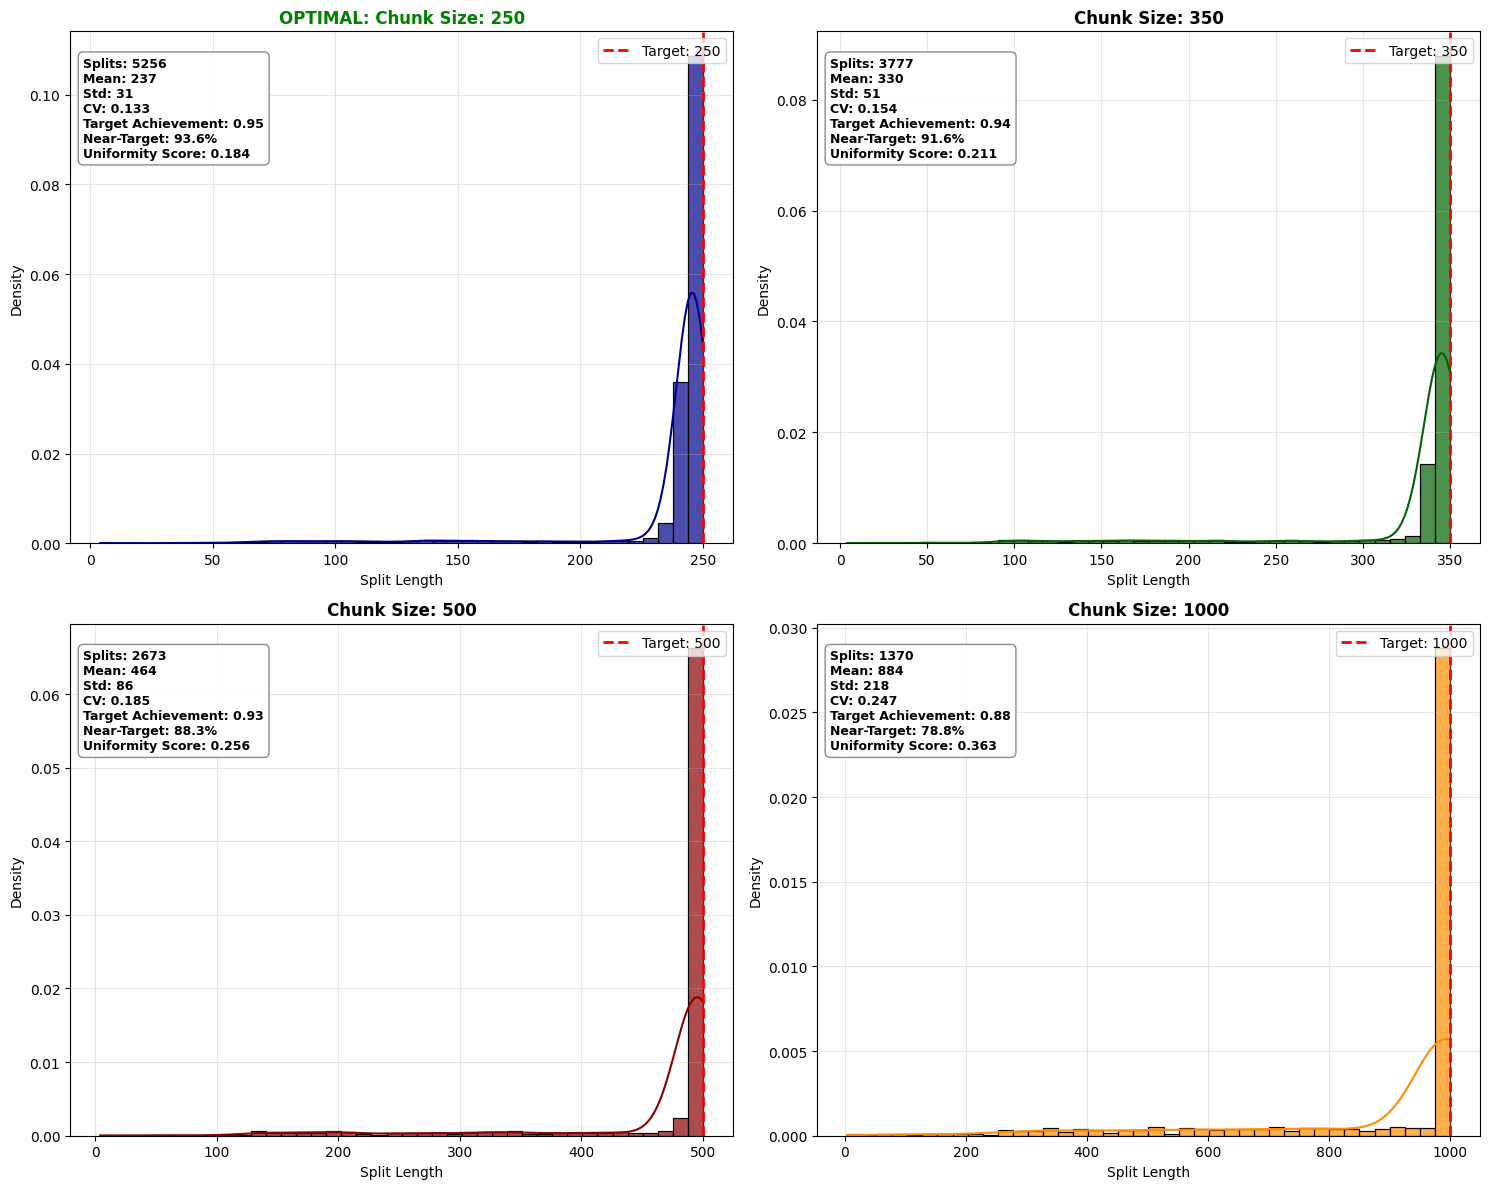


🏆 RECOMMENDATIONS
📌 OPTIMAL CHUNK SIZE: 250

Why 250 is optimal:
   ✅ Lowest uniformity score: 0.184
   ✅ Best coefficient of variation: 0.133
   ✅ Target achievement: 0.95
   ✅ Near-target ratio: 93.6%

📋 SUMMARY COMPARISON:
Chunk Size   Uniformity   CV       Target Ach.  Near-Target 
------------------------------------------------------------
🏆 250        0.184        0.133    0.95         93.6%       
   350        0.211        0.154    0.94         91.6%       
   500        0.256        0.185    0.93         88.3%       
   1000       0.363        0.247    0.88         78.8%       

📊 PANDAS DATAFRAME SUMMARY
   Rank  Chunk_Size  Uniformity_Score      CV  Target_Achievement  Near_Target_Ratio  Chunk_Count  Mean_Length  Std_Deviation  Median_Q50  Mode  Mode_Count
0     1         250            0.1844  0.1325               0.948              0.936         5256        237.0           31.4       245.0   249         726
1     2         350            0.2114  0.1539               0.94

In [ ]:
analysis_results = analyze_optimal_chunking(
    Doc_list,
    chunk_sizes=[250, 350, 500, 1000],
    overlap_ratio=0.25,
    show_plot=True,
    return_dataframe=True
)

In [ ]:
# Access the DataFrame summary
df_summary = analysis_results['df_summary']
print("\nDataFrame Summary:")
df_summary


DataFrame Summary:


,Rank,Chunk_Size,Uniformity_Score,CV,Target_Achievement,Near_Target_Ratio,Chunk_Count,Mean_Length,Std_Deviation,Median_Q50,Mode,Mode_Count
0,1,250,0.1844,0.1325,0.948,0.936,5256,237.0,31.4,245.0,249,726
1,2,350,0.2114,0.1539,0.942,0.916,3777,329.9,50.8,345.0,348,496
2,3,500,0.2563,0.1849,0.929,0.883,2673,464.3,85.9,495.0,497,333
3,4,1000,0.3629,0.2467,0.884,0.788,1370,883.8,218.0,994.0,998,136


# Embedded Vector Storage

At this point we need to express our chunked text as dense vector, so it is necessary to apply an **Embedding technique**. Remeber that the logical rapresentation of the **Query** must be the same as the documents one, then we must apply the same Embedding approach.
We will use the following embedding models:
1. [**Sentence Transformer**](https://www.sbert.net) based on the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) or other alternative model. Here you can find a quick [overview](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) of the available pretrained models which can be also finetuned to increase the performances for our specific application.
2. [**Cross Encoders**](https://www.sbert.net) model is also a valid alternative, in particular they are often used to re-rank the top-k results from a Sentence Transformer model.

In [ ]:
device = "cpu"
cache_folder_path = '/content/Sentences_Model_Cache'
batch_size = 32

In [ ]:
# Load a pretrained Sentence Transformer model
Sentence_Embedding_Model = SentenceTransformer(model_name_or_path = "all-MiniLM-L6-v2",
                                               similarity_fn_name  = 'cosine', # "dot", "euclidean"(L2 norm), "manatthan"(L1 norm) otherwise
                                               device = device,
                                               cache_folder  = cache_folder_path)

# Extract the text content from the Document objects
texts_to_encode = [chunk.page_content for chunk in Rec_CharDoc_splits]

# Generate the embeddings
Sentence_embeddings = Sentence_Embedding_Model.encode(sentences = texts_to_encode,
                                                      prompt = None,
                                                      batch_size = batch_size,
                                                      show_progress_bar = True,
                                                      precision = "float32",
                                                      normalize_embeddings = False,
                                                      output_value = "sentence_embedding", # "token_embeddings" otherwise
                                                      convert_to_numpy = True,
                                                      device = device)

print('Embedding Dimension: ', Sentence_embeddings.shape[1],'\nNumber of document: ', Sentence_embeddings.shape[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

Embedding Dimension:  384 
Number of document:  2673


In [ ]:
assert Sentence_embeddings.shape[0] == len(Rec_CharDoc_splits)
np.savetxt("Sentence_embeddings_.chunksize250_overlap50.csv", Sentence_embeddings, delimiter=",", fmt="%f")

These model allow also the computation of the **Similarity** between two collections of embeddings. The output will be a matrix with the similarity scores between all embeddings from the first parameter and all embeddings from the second parameter. This differs from `similarity_pairwise` which computes the similarity between each pair of embeddings, of course one of them can be also the embedding of the query provided by the user. Compute the similarity

In [ ]:
# Calculate the embedding similarities using the "similarity_fn_name" settings
similarities = Sentence_Embedding_Model.similarity(Sentence_embeddings, Sentence_embeddings)
print(similarities)

tensor([[1.0000, 0.8345, 0.7390,  ..., 0.3760, 0.2967, 0.2306],
        [0.8345, 1.0000, 0.7700,  ..., 0.3485, 0.2459, 0.1806],
        [0.7390, 0.7700, 1.0000,  ..., 0.2591, 0.1496, 0.1720],
        ...,
        [0.3760, 0.3485, 0.2591,  ..., 1.0000, 0.6733, 0.4882],
        [0.2967, 0.2459, 0.1496,  ..., 0.6733, 1.0000, 0.6082],
        [0.2306, 0.1806, 0.1720,  ..., 0.4882, 0.6082, 1.0000]])


In [ ]:
for similarity in ['cosine', 'dot', 'euclidean', 'manhattan']:
  Sentence_Embedding_Model.similarity_fn_name = similarity
  similarities = Sentence_Embedding_Model.similarity(Sentence_embeddings, Sentence_embeddings)
  print(f'{similarity} similarity results:\n{similarities}\n')

# Lets set again the cosine similarity for the model
Sentence_Embedding_Model.similarity_fn_name = 'cosine'

cosine similarity results:
tensor([[1.0000, 0.8345, 0.7390,  ..., 0.3760, 0.2967, 0.2306],
        [0.8345, 1.0000, 0.7700,  ..., 0.3485, 0.2459, 0.1806],
        [0.7390, 0.7700, 1.0000,  ..., 0.2591, 0.1496, 0.1720],
        ...,
        [0.3760, 0.3485, 0.2591,  ..., 1.0000, 0.6733, 0.4882],
        [0.2967, 0.2459, 0.1496,  ..., 0.6733, 1.0000, 0.6082],
        [0.2306, 0.1806, 0.1720,  ..., 0.4882, 0.6082, 1.0000]])

dot similarity results:
tensor([[1.0000, 0.8345, 0.7390,  ..., 0.3760, 0.2967, 0.2306],
        [0.8345, 1.0000, 0.7700,  ..., 0.3485, 0.2459, 0.1806],
        [0.7390, 0.7700, 1.0000,  ..., 0.2591, 0.1496, 0.1720],
        ...,
        [0.3760, 0.3485, 0.2591,  ..., 1.0000, 0.6733, 0.4882],
        [0.2967, 0.2459, 0.1496,  ..., 0.6733, 1.0000, 0.6082],
        [0.2306, 0.1806, 0.1720,  ..., 0.4882, 0.6082, 1.0000]])

euclidean similarity results:
tensor([[-0.0000e+00, -5.7527e-01, -7.2244e-01,  ..., -1.1171e+00,
         -1.1860e+00, -1.2405e+00],
        [-5.7527e-

Since i want to test different parameters for the chunk size, i will compute and store the relative embeddings for different values of chunkization:

In [ ]:
chunk_sizes = [250, 500, 750]

for chunk_size in chunk_sizes:
  Rec_Char_splitter  = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                                      chunk_overlap = chunk_size//4, # 25% overlap
                                                      separators  = ["\n\n", "\n", " ", ""])

  Rec_CharDoc_splits = Rec_Char_splitter.split_documents(Doc_list)

  # Load a pretrained Sentence Transformer model

  Sentence_Embedding_Model = SentenceTransformer(model_name_or_path = "all-MiniLM-L6-v2",
                                                similarity_fn_name  = 'cosine', # "dot", "euclidean"(L2 norm), "manatthan"(L1 norm) otherwise
                                                device = device,
                                                cache_folder  = cache_folder_path)

  # Extract the text content from the Document objects
  texts_to_encode = [chunk.page_content for chunk in Rec_CharDoc_splits]
  texts_metadata = [chunk.metadata for chunk in Rec_CharDoc_splits]

  # Generate the embeddings
  Sentence_embeddings = Sentence_Embedding_Model.encode(sentences = texts_to_encode,
                                                        prompt = None,
                                                        batch_size = batch_size,
                                                        show_progress_bar = True,
                                                        precision = "float32",
                                                        normalize_embeddings = False,
                                                        output_value = "sentence_embedding", # "token_embeddings" otherwise
                                                        convert_to_numpy = True,
                                                        device = device)

  assert Sentence_embeddings.shape[0] == len(Rec_CharDoc_splits)
  np.savetxt(f"Sentence_embeddings_.chunksize{chunk_size}_overlap{chunk_size//4}.csv", Sentence_embeddings, delimiter=",", fmt="%f")
  print('Embedding Dimension: ', Sentence_embeddings.shape[1],'\nNumber of document: ', Sentence_embeddings.shape[0],'\n')
  df_metadata = pd.DataFrame(texts_metadata)
  df_metadata.to_csv(f"Sentence_embeddings_metadata_chunksize{chunk_size}_overlap{chunk_size//4}.csv", index=False)
  print('Metadata dataset dimensions: ', df_metadata.shape)

Batches:   0%|          | 0/165 [00:00<?, ?it/s]

Embedding Dimension:  384 
Number of document:  5256 

Metadata dataset dimensions:  (5256, 6)


Batches:   0%|          | 0/84 [00:00<?, ?it/s]

Embedding Dimension:  384 
Number of document:  2673 

Metadata dataset dimensions:  (2673, 6)


Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Embedding Dimension:  384 
Number of document:  1809 

Metadata dataset dimensions:  (1809, 6)


It is also foundamental to map each chunk of embedded text with the relative metadata in order to give some references whenever such docments are retrived for users.

In [ ]:
metadata_dataset = pd.read_csv("/content/Sentence_embeddings_metadata_chunksize250_overlap62.csv")
embedded_dataset = pd.read_csv("/content/Sentence_embeddings_.chunksize250_overlap62.csv", header = None)

In [ ]:
def metadata_to_chunkedText(idx:int, metadata_dataset: pd.DataFrame, embedded_dataset: pd.DataFrame):

    assert metadata_dataset.shape[0] == embedded_dataset.shape[0]

    largest_index = metadata_dataset.shape[0] - 1

    while True:
        try:
            idx_requested = idx
            if idx_requested < 0 or idx_requested > largest_index:
                print(f'Index must be between 0 and {largest_index}')
                continue

        except ValueError:
            print('Please enter a valid integer')
            continue
        except KeyboardInterrupt:
            print('\nOperation cancelled')
            return None, None

        # Access DataFrame rows using .iloc for positional indexing
        selected_metadata = metadata_dataset.iloc[idx_requested]
        selected_embedded = embedded_dataset.iloc[idx_requested] if hasattr(embedded_dataset, 'iloc') else embedded_dataset[idx_requested]

        print(f'\nIndex {idx_requested}')
        print(f'Metadata: {selected_metadata}')

        return selected_metadata, selected_embedded

In [ ]:
# Example of usage
meta_data, embedded_vec = metadata_to_chunkedText(5, metadata_dataset, embedded_dataset)


Index 5
Metadata: source         https://urban-mobility-observatory.transport.e...
title          UPPER launches two new integrated digital tool...
date                                                     Unknown
author                                                   Unknown
keywords       transport research, transport statistics, sust...
description    The UPPER project launches U-KNOW and U-TRANSF...
Name: 5, dtype: object


In [ ]:
embedded_dataset.head(3)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.085746,-0.049067,-0.032090,-0.043805,0.070061,0.003877,-0.015414,0.035366,-0.039323,0.032534,...,0.048330,-0.002365,0.008056,0.004729,0.016028,0.024356,0.057878,0.014258,-0.038248,0.108288
1,0.069853,-0.033104,-0.046841,-0.024837,0.067232,0.002727,0.067914,-0.017631,-0.084815,-0.007071,...,0.088184,0.002349,-0.022925,-0.040149,0.092188,-0.010167,0.056340,0.054390,-0.001398,0.092119
2,0.125915,-0.040064,-0.011179,0.016002,0.045025,0.035861,0.040665,0.010848,-0.094185,0.027343,...,0.094122,0.004443,-0.004262,-0.043547,0.015415,0.024295,-0.030708,0.004992,0.009609,0.119851


## FAISS DataBase

All the information mentioned are available at official [Faiss Doc](https://github.com/facebookresearch/faiss/wiki) but i will write down the most usefull tips for our study case.

* Faiss is built around the `Index object`. It encapsulates the set of database vectors, and optionally preprocesses them to make searching efficient. When the index is built and trained, two operations can be performed on the index: `add` and `search`.

* To **speed up** the search, it is possible to segment the dataset into pieces. We define **Voronoi cells** in the d-dimensional space, and each database vector falls in one of the cells. At search time, only the database vectors $x_{d}$ contained in the cell the query $x_q$ falls in and a few neighboring ones are compared against the query vector.

* The `IndexIVFFlat` also requires another index, the **quantizer**, that assigns vectors to **Voronoi cells** . Each cell is defined by a centroid, and finding the Voronoi cell a vector falls in consists in finding the nearest neighbor of the vector in the set of centroids. This is the task of the other index, which is typically an `IndexFlatL2`.

* The choice of an Index depends on the usual **trade-off** between **speed, accuracy and memory**. Since in our case the number of documents does not even reach $100$, the best choice might be to focus on the accuracy. The official documentation provides also some [Guidelines to properly choose an index](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index) and a quick overview on the main [Faiss Indexes](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes) .

* Since the user must have the possibility to check the source of the generated response, it can be usefull to customize the ids of the indexes using something like [`IndexIDMap`](https://github.com/facebookresearch/faiss/wiki/Pre--and-post-processing#the-indexidmap) .

* In addition we can also use the `index_factory` function which interprets a string to produce a composite Faiss index. The string is a comma-separated list of components. It is intended to facilitate the construction of index structures, especially if they are nested. The index_factory argument typically includes a preprocessing component, and inverted file and an encoding component. This [page](https://github.com/facebookresearch/faiss/wiki/The-index-factory) summarizes the index_factory components and arguments.

* In the end, if one got some speed problem, there is also a guide that explains [how to make Faiss **faster**](https://github.com/facebookresearch/faiss/wiki/How-to-make-Faiss-run-faster) .

In [ ]:
# Notation alignment (250 as chunk_size)
Sentence_embeddings = embedded_dataset.to_numpy()

In [ ]:
# Vector DB parameters
d = Sentence_embeddings.shape[1]
DataBase = Sentence_embeddings
query = 'Free Palestine'
xq = Sentence_Embedding_Model.encode(query).reshape(1, -1)

print(f'Vector Dimension: {d}\nNumber of documents: {Sentence_embeddings.shape[0]}\nQuery shape:{xq.shape}')

Vector Dimension: 384
Number of documents: 5256
Query shape:(1, 384)


## K-Means Clustering

In this section we are going to perform a K-Means cluster analysis of the embedded vectors for all the selected values of the chunksize. In order to evaluate the quality of such clusters, we will use both the shilouette score and the graphical elbow method to select the optimal number of clusters.

In [ ]:
def K_Means(Sentence_embeddings, ncentroids: list, niter=30, verbose=False, show_plots=True):
    """
    Runs KMeans clustering using FAISS and evaluates with WCSS and Silhouette Score.
    Displays both Elbow and Silhouette plots side by side.

    Parameters:
        Sentence_embeddings (np.ndarray): Feature vectors.
        ncentroids (list[int]): List of k values to try.
        niter (int): Max iterations for FAISS KMeans.
        verbose (bool): Verbose FAISS output.
        show_plots (bool): Show 1x2 subplot with WCSS and silhouette scores.

    Returns:
        WCSS_list (list[float]): Final within-cluster sum of squares.
        silhouette_list (list[float or None]): Silhouette score for each k.
    """
    d = Sentence_embeddings.shape[1]
    DataBase = Sentence_embeddings

    WCSS_list = []
    silhouette_list = []

    for n in ncentroids:
        kmeans = faiss.Kmeans(d, n, niter=niter, verbose=verbose)
        kmeans.train(DataBase)
        WCSS = kmeans.obj[-1]
        WCSS_list.append(WCSS)

        # Get cluster labels
        _, labels = kmeans.index.search(DataBase, 1)
        labels = labels.reshape(-1)

        if n > 1:
            score = silhouette_score(DataBase, labels)
        else:
            score = None

        silhouette_list.append(score)

    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))

        # Elbow plot
        axs[0].plot(ncentroids, WCSS_list, marker='o', color = 'blue')
        axs[0].set_title('Elbow Method (WCSS)')
        axs[0].set_xlabel('Number of Clusters')
        axs[0].set_ylabel('WCSS')
        axs[0].grid(True)

        # Silhouette Score plot
        axs[1].plot(ncentroids, silhouette_list, marker='o', color='darkgreen')
        axs[1].set_title('Silhouette Score')
        axs[1].set_xlabel('Number of Clusters')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    return WCSS_list, silhouette_list

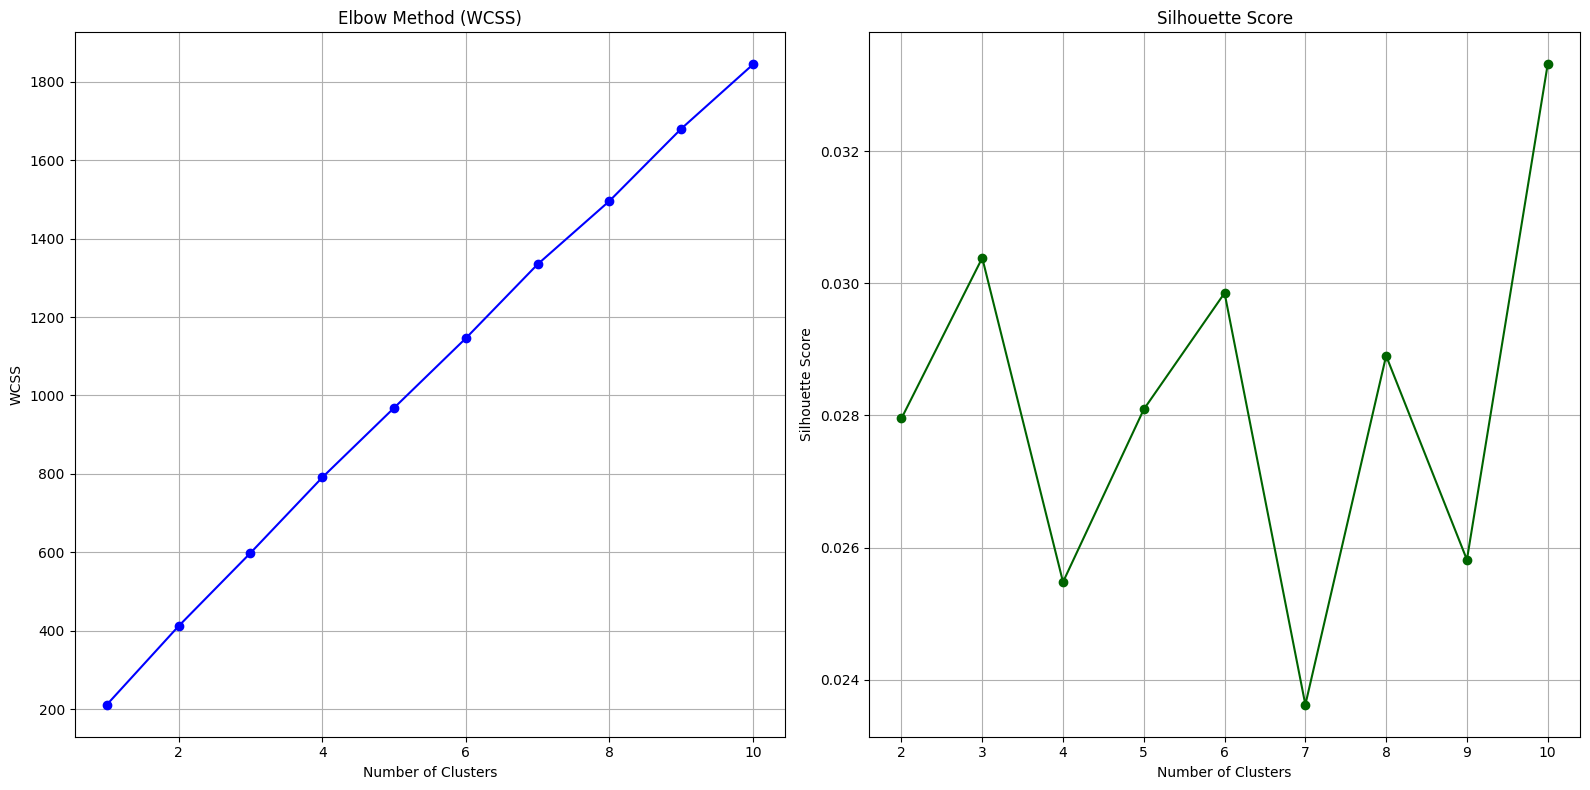

In [ ]:
WCSS, stats = K_Means(Sentence_embeddings,[n for n in range(1,11)])

Now lets'perform it for different values of the chunk size:

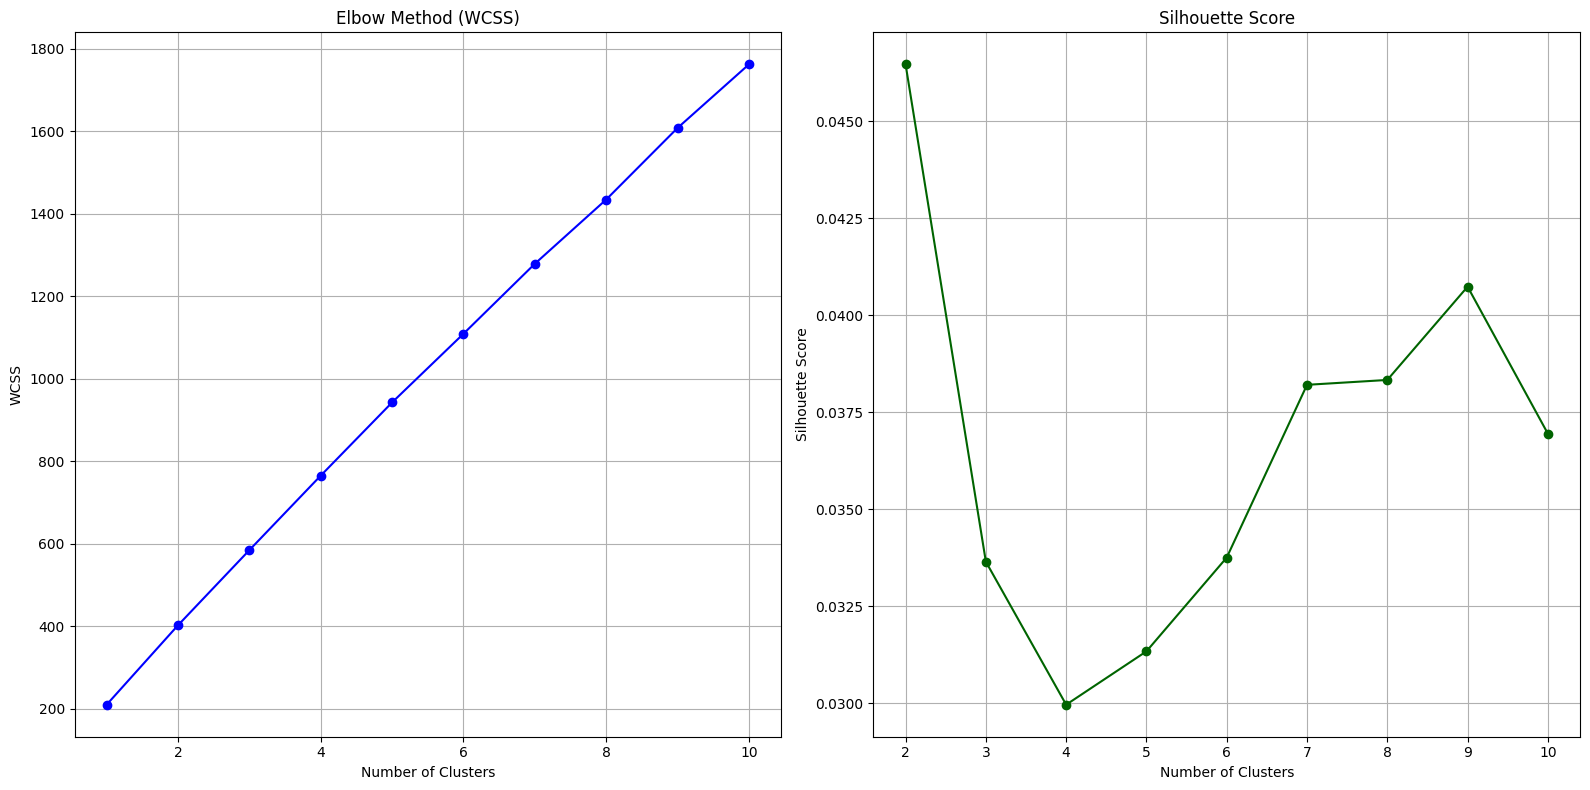

In [ ]:
Sentence_Embedding_500 = np.loadtxt("/content/Sentence_embeddings_.chunksize500_overlap125.csv", delimiter=",")
WCSS, stats = K_Means(Sentence_Embedding_500,[n for n in range(1,11)])

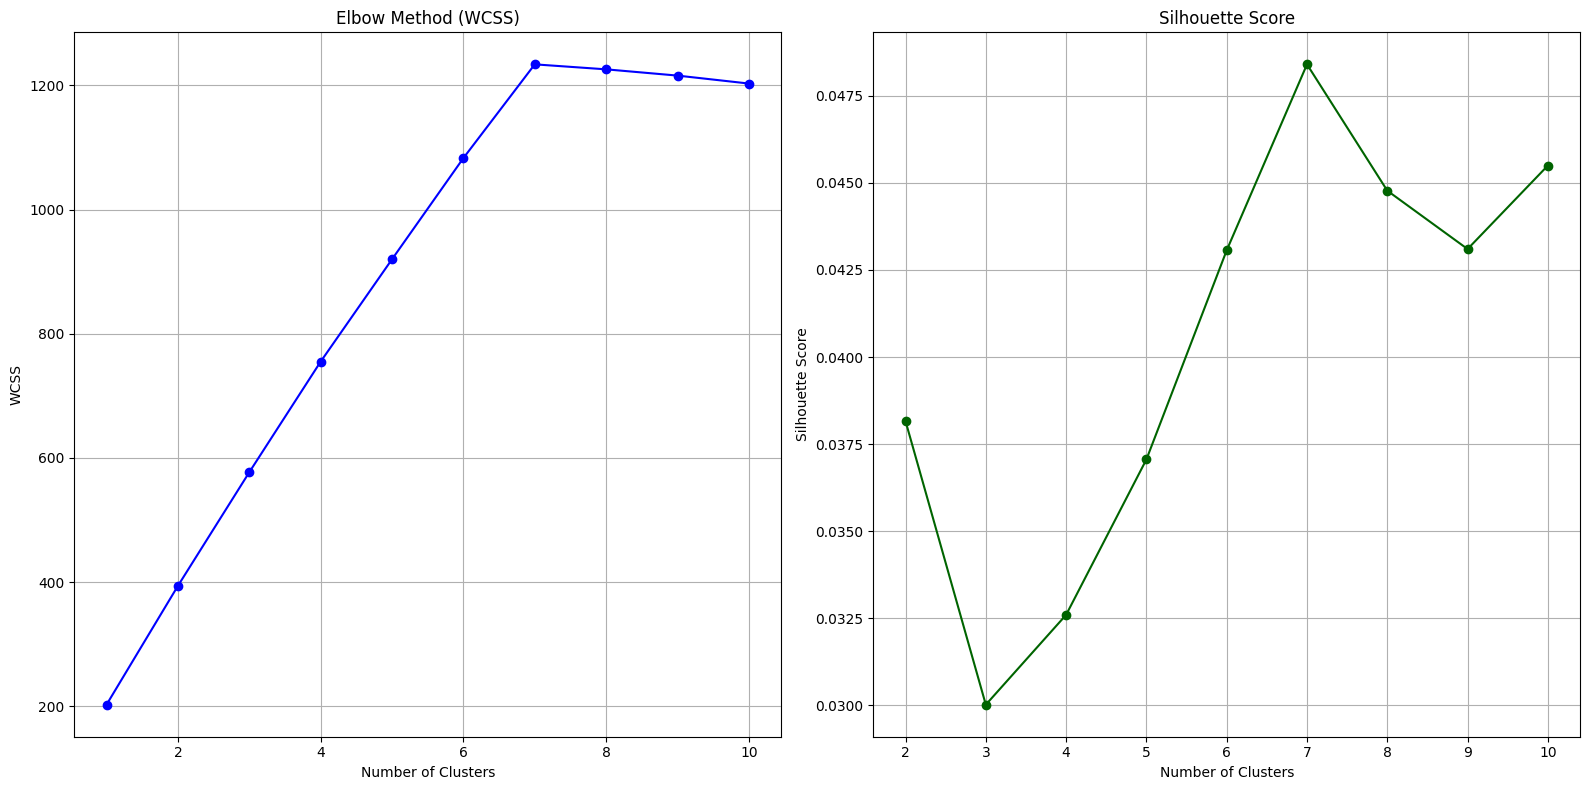

In [ ]:
Sentence_Embedding_1000 = np.loadtxt("/content/Sentence_embeddings_.chunksize750_overlap187.csv", delimiter=",")
WCSS, stats = K_Means(Sentence_Embedding_1000,[n for n in range(1,11)])

Based on these results we can state that, since for each selected chunk size the optimal number of clusters is $1$, the `IVFFlat Index` identifies only a single Voronoi Cell, so it performs the similarity search considering the entire database for a given query.

There can be several motivations:
1. The news published in the last months consist of similar contents ;
2. The model used to perform the embeddings is not particulary appropriate to discriminate the documents, and so it could map different news with similar dense vector ;
3. The K-Means algorithm assumption (spherical distribution) may be too strong.
4. A combination of the previous motivations.

At this point it is clear that we can directly use the `IndexFlatL2`.

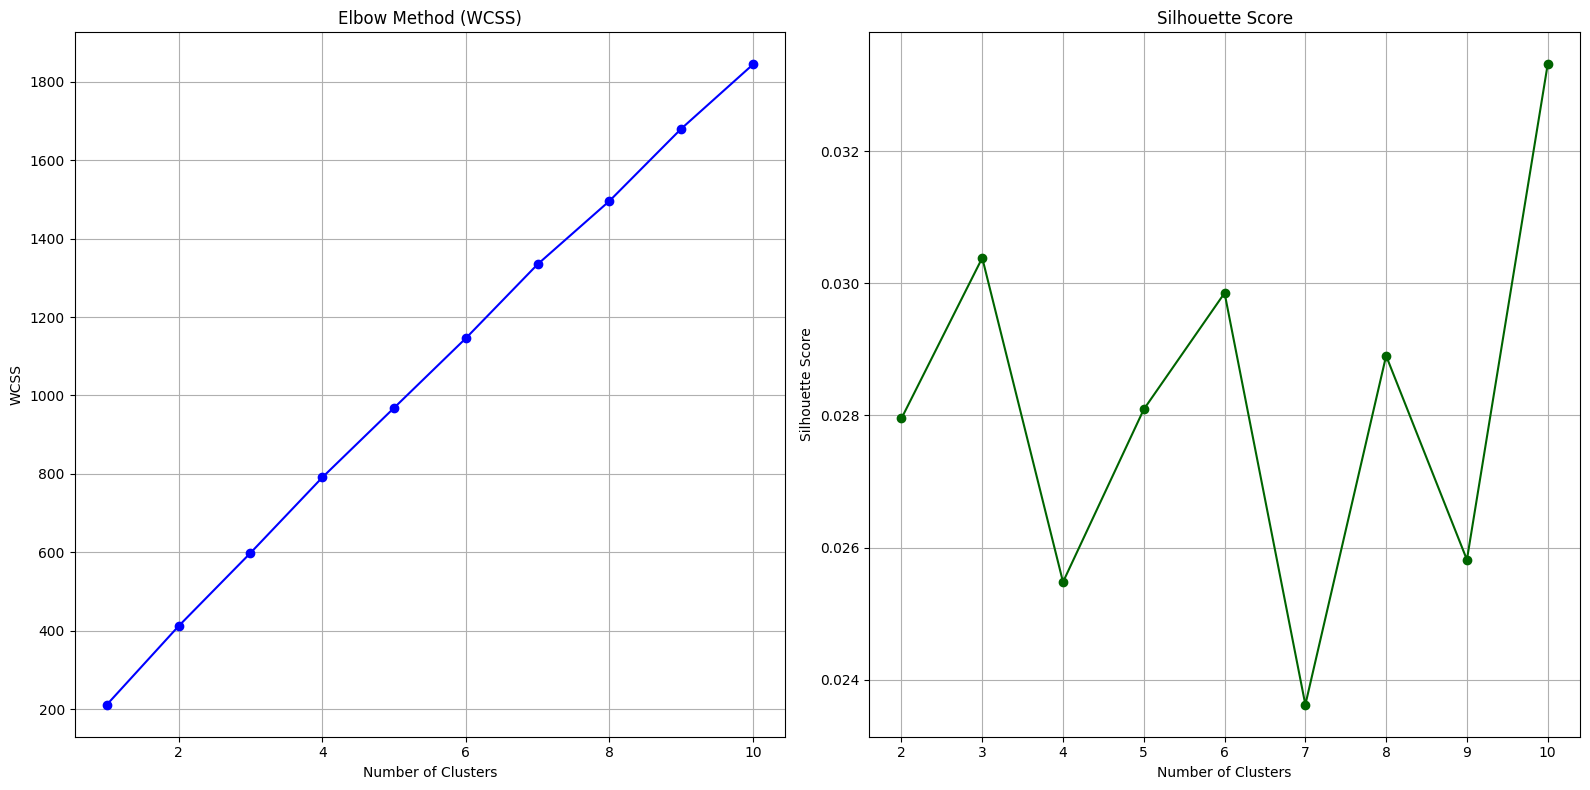

In [ ]:
WCSS, stats = K_Means(Sentence_embeddings,[n for n in range(1,11)])

## FlatIndex

In [ ]:
index = faiss.IndexFlatL2(d)
print(index.is_trained)
index.add(Sentence_Embedding_500)                  # add vectors to the index
print(index.ntotal)

True
2673


In [ ]:
k = 5
D, I = index.search(xq, k)
print(I[0])

[393 428 704 705 700]


In [ ]:
metadata_dataset_500 = pd.read_csv("Sentence_embeddings_metadata_chunksize500_overlap125.csv")

In [ ]:
for idx in I[0]:
  metadata_to_chunkedText(idx, metadata_dataset_500, Sentence_Embedding_500)


Index 393
Metadata: source         https://north-africa-middle-east-gulf.ec.europ...
title          EU boosts humanitarian response for Gaza, Syri...
date                                                 21 May 2025
author         Directorate-General for the Middle East, North...
keywords                           European neighbourhood policy
description    In response to the rapidly deteriorating situa...
Name: 393, dtype: object

Index 428
Metadata: source         https://civil-protection-humanitarian-aid.ec.e...
title          EU boosts humanitarian response for Gaza, Syri...
date                                                 21 May 2025
author         Directorate-General for European Civil Protect...
keywords                                        humanitarian aid
description    In response to the rapidly deteriorating situa...
Name: 428, dtype: object

Index 704
Metadata: source         https://north-africa-middle-east-gulf.ec.europ...
title          Joint donor statement on hu

This will be vey usefull to give the source of the responde generated by the LLM.

# RAG

The following section will be contructed such that it can be runned indipendently from the previous sections.

## LangChain Modules Import

Here the links to get the Huggingface documentation:
*  [Transformers](https://huggingface.co/docs/transformers/index)
* [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto)
  * [Auto Tokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer)
  * [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSeq2SeqLM)
  * [AutoModelForQuestionAnswering](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForQuestionAnswering)
* [Pipeline](https://huggingface.co/docs/transformers/pipeline_tutorial)
  - [Generation Parameters](https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationConfig)
* [Prompt Template](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html#prompttemplate)
* [LLM Chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.llm.LLMChain.html)
* [Hugging Face Pipeline wrapper](https://python.langchain.com/api_reference/huggingface/llms/langchain_huggingface.llms.huggingface_pipeline.HuggingFacePipeline.html#huggingfacepipeline)

I found supportive and intersting material on Hugging Face, [RAG and Tools](https://huggingface.co/docs/transformers/chat_extras#rag).

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForQuestionAnswering, pipeline
from langchain import PromptTemplate, LLMChain
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


import textwrap
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

## Sentence Embeddings & Retriver

The first step consist of downloading our document collection, split each document in chunks, compute their embedding and then store the dense vector obtained in a Vector DB.

In [ ]:
def dataset_to_documents(df: pd.DataFrame) -> List[Document]:
    """
    Convert DataFrame back to LangChain Documents if needed.
    """
    docs = []
    for _, row in df.iterrows():
        metadata = {
            'source': row.get('source', ''),
            'title': row.get('title', ''),
            'date': row.get('date', ''),
            'author': row.get('author', ''),
            'keywords': row.get('keywords', ''),
            'description': row.get('description', '')
        }
        doc = Document(
            page_content=row.get('content', ''),
            metadata=metadata
        )
        docs.append(doc)

    print(f"📄 Converted {len(docs)} DataFrame rows to LangChain Documents")
    return docs

In [ ]:
# Import the document collection
df_extracted_doc = pd.read_csv("/content/extracted_documents.csv")
Doc_list = dataset_to_documents(df_extracted_doc)

# Text Splitting
chunk_size = 250
Rec_Char_splitter = RecursiveCharacterTextSplitter(chunk_size = chunk_size,
                                                   chunk_overlap = chunk_size // 4, # 25% overlap
                                                   separators  = ["\n\n", "\n", " ", ""])

Rec_CharDoc_splits = Rec_Char_splitter.split_documents(Doc_list)
chunked_doc = [chunk.page_content for chunk in Rec_CharDoc_splits]


# Sentence Embedding
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu', "similarity_fn_name": 'cosine'}
encode_kwargs = {'normalize_embeddings': False,
                 'batch_size': 32,
                 'precision': "float32",
                 "convert_to_numpy" : True}
Sentence_Embedding_HF = HuggingFaceEmbeddings(model_name = model_name,
                                              model_kwargs = model_kwargs,
                                              encode_kwargs = encode_kwargs)

# Faiss VectorDB
FAISS_vector_store = FAISS.from_documents(documents = Rec_CharDoc_splits,
                                          embedding = Sentence_Embedding_HF)

# Faiss as a Retriver
retriever = FAISS_vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5, "lambda_mult": 0.85})
results = retriever.invoke("Free Palestine")

📄 Converted 296 DataFrame rows to LangChain Documents


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
results = retriever.invoke("What are the benefits of AI?")
results[0].metadata

{'source': 'https://european-masters-translation-blog.ec.europa.eu/articles-emt-blog/how-ai-stole-christmas-fight-ip-2025-05-05_en',
 'title': 'How AI stole Christmas: a fight for IP',
 'date': '5 May 2025',
 'author': 'Directorate-General for Translation',
 'keywords': 'translation',
 'description': 'By Sarah Glaser, Laëtitia Joly and Katia Pinquier, students studying for a Masters in Applied Foreign Languages at Grenoble Alpes University'}

## LLMs for Generation

In [ ]:
# Load "google/flan-t5-large" as pre-trained model from Hugging Face
modelName1 = "google/flan-t5-large"
tokenizer1 = AutoTokenizer.from_pretrained(modelName1)
T2T_model1 = AutoModelForSeq2SeqLM.from_pretrained(modelName1)

# --- Create the Hugging Face pipeline first ---
T2T_pipe1 = pipeline(task = "text2text-generation",
                    model = T2T_model1,
                    tokenizer = tokenizer1,
                    max_new_tokens = 512,
                    min_new_tokens = 64,
                    do_sample = True,
                    temperature = 0.7,
                    )

# --- Wrap the pipeline in a HuggingFacePipeline object ---
# Pass the created pipeline object directly to the 'pipeline' parameter
llm_googleT5_large = HuggingFacePipeline(pipeline = T2T_pipe1)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-56-4121303945>:18: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm_googleT5_large = HuggingFacePipeline(pipeline = T2T_pipe1)


In [ ]:
modelName2 = "google/flan-t5-small"
tokenizer2 = AutoTokenizer.from_pretrained(modelName2)
T2T_model2 = AutoModelForSeq2SeqLM.from_pretrained(modelName2)

# --- Create the Hugging Face pipeline first ---
T2T_pipe2 = pipeline(task = "text2text-generation",
                    model = T2T_model2,
                    tokenizer = tokenizer2,
                    max_new_tokens = 512,
                    min_new_tokens = 64,
                    do_sample = True,
                    temperature = 0.7,
                    )

# --- Wrap the pipeline in a HuggingFacePipeline object ---
# Pass the created pipeline object directly to the 'pipeline' parameter
llm_googleT5_small = HuggingFacePipeline(pipeline = T2T_pipe2)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


## RAG Chain

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def format_references(docs):
    references = []
    for i, doc in enumerate(docs, start=1):
        source = doc.metadata.get('source', 'unknown source')
        date = doc.metadata.get('date', 'unknown date')
        title = doc.metadata.get('title', 'Untitled')
        author = doc.metadata.get('author', 'unknown author')

        ident = "  "
        reference = (
            f"• Document {i}\n"
            f"{ident}- Title: {title}\n"
            f"{ident}- Author: {author}\n"
            f"{ident}- Date: {date}\n"
            f"{ident}- Source: {source}"
        )
        references.append(reference)

    return "\n\n".join(references)

def format_response(response):
  return textwrap.fill(response, width=80)

# Prompt
template1 = """Context: {context}
Question: {question}

Answer in max 2 sentences using only the context above as a professional journalist.
Always include the sources listed below in your response.
If no relevant info, say "Information not available in my sources."

Sources:
{references}"""

template2 = """Context: {context}
Question: {question}

Answer in max 2 sentences using only the context above.

{references}"""

prompt = PromptTemplate.from_template(template2)

# Retriever
retriever = FAISS_vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 2, "lambda_mult": 0.85})

# Chain
rag_chain = (
        {"context": retriever | format_docs,
        "references": retriever | format_references,
        "question": RunnablePassthrough()}
        | prompt
        | llm_googleT5_large
        | StrOutputParser()
        | RunnableLambda(format_response)
        )

In [ ]:
response = rag_chain.invoke("What is happened in technology domain in EU")

In [ ]:
print(response)

Document 1 - Title: Technology Infrastructures in the spotlight: a strategic
asset for European competitiveness - Author: Directorate-General for Research
and Innovation - Date: 8 May 2025 - Source: https://research-and-
innovation.ec.europa.eu/news/all-research-and-innovation-news/technology-
infrastructures-spotlight-strategic-asset-european-competitiveness-2025-05-08_en
• Document 2 - Title: 200 territories join EU initiative to put innovation
policies into action - Author: Joint Research Centre - Date: 29 April 2025 -
Source: https://place-based-innovation.ec.europa.eu/innovation-place-based-
transformation-news/200-territories-join-eu-initiative-put-innovation-policies-
action-2025-04-29_en


Since the LLM used is relatively small, it cannot manage to much complex prompting,in fact the model either succeeds in providing a comprehensive answer without providing the sources from which it learned the news, or it provides the sources but without being  generative. In this case, the context window of $512$ tokens is quite stringent. The idea at this point is to provide the sources of the quoted information after the model has generated the answer. To do this, it is not strictly necessary to use the langchain syntax, on the other hand, since we are trying to reproduce a direct acyclic graph, placing the instructions sequentially leads to the same result, but it is still possible to use the rag chain using `RunnableLambda` as the only element.

In [ ]:
# Usefull funciton for formatting

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def format_references(docs):
    references = []
    for i, doc in enumerate(docs, start=1):
        source = doc.metadata.get('source', 'unknown source')
        date = doc.metadata.get('date', 'unknown date')
        title = doc.metadata.get('title', 'Untitled')
        author = doc.metadata.get('author', 'unknown author')

        ident = "  "
        reference = (
            f"• Document {i}\n"
            f"{ident}- Title: {title}\n"
            f"{ident}- Author: {author}\n"
            f"{ident}- Date: {date}\n"
            f"{ident}- Source: {source}"
        )
        references.append(reference)

    return "\n\n".join(references)

def format_response(response):
  return textwrap.fill(response, width=80)

In [ ]:
def generate_answer_with_sources(question):
    # Retriever
    retriever = FAISS_vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 4, "lambda_mult": 0.85})

    # Get documents
    docs = retriever.invoke(question)
    context = format_docs(docs)

    # Generate answer
    system_prompt = "You are a professional journalist assistant that provides accurate answers about European Commission news from April and May 2025.\
    Formulate the answer only on the context, if it is not enought say: 'Information not available in my sources.'"
    prompt = f"Context: {context}\nQuestion: {question}\n{system_prompt}\nAnswer:"
    answer = llm_googleT5_large.invoke(prompt).strip()
    formatteded_response = textwrap.fill(answer, width=80)


    # Add sources separately
    sources = format_references(docs)
    return f"{formatteded_response}\n\nSources:\n{sources}"

In [ ]:
query = "What is happened in technology domain in EU"

In [ ]:
result = generate_answer_with_sources(query)
print(result)

The EU Preparatory Action will bring them together to develop more comprehensive
and versatile approaches, enabling the creation of transferable to that, the
demand for digital workers is likely to grow. The 2023 Skills in Transition: the
way to 2035 report suggests there will be strong demand for ICT professionals up
to 2035. Digital skills are a key priority for the EU. More than 70% of and
mobilising investments in TIs are crucial to ensure that European industries
remain at the forefront of technological advancements.

Sources:
• Document 1
  - Title: Technology Infrastructures in the spotlight: a strategic asset for European competitiveness
  - Author: Directorate-General for Research and Innovation
  - Date: 8 May 2025
  - Source: https://research-and-innovation.ec.europa.eu/news/all-research-and-innovation-news/technology-infrastructures-spotlight-strategic-asset-european-competitiveness-2025-05-08_en

• Document 2
  - Title: 200 territories join EU initiative to put innovation 

As mentioned before, we can do the same with LangChain:

In [ ]:
rag_chain_short = (RunnableLambda(generate_answer_with_sources))
result = rag_chain_short.invoke(query)
print(result)

The EU Preparatory Action will bring them together to develop more comprehensive
and versatile approaches, enabling the creation of transferable to that, the
demand for digital workers is likely to grow. The 2023 Skills in Transition: the
way to 2035 report suggests there will be strong demand for ICT professionals up
to 2035. Digital skills are a key priority for the EU. More than 70% of and
mobilising investments in TIs are crucial to ensure that European industries
remain at the forefront of technological advancements.

Sources:
• Document 1
  - Title: Technology Infrastructures in the spotlight: a strategic asset for European competitiveness
  - Author: Directorate-General for Research and Innovation
  - Date: 8 May 2025
  - Source: https://research-and-innovation.ec.europa.eu/news/all-research-and-innovation-news/technology-infrastructures-spotlight-strategic-asset-european-competitiveness-2025-05-08_en

• Document 2
  - Title: 200 territories join EU initiative to put innovation 

# Gradio


As stated in the documentation:


> Gradio is an open-source Python package that allows you to quickly build a demo or web application for your machine learning model, API, or any arbitrary Python function.



Of course, the core of our API will be the following function:

In [ ]:
# RAG Default Functioning
def generate_answer_with_sources(question, LM_size = 'large'):

    # Retriever
    retriever = FAISS_vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 4, "lambda_mult": 0.85})

    # Get documents
    docs = retriever.invoke(question)
    context = format_docs(docs)

    # Generate answer
    system_prompt = "You are a professional journalist assistant that provides accurate answers about European Commission news from April and May 2025.\
    Formulate the answer only on the context, if it is not enought say: 'Information not available in my sources.'"
    prompt = f"Context: {context}\nQuestion: {question}\n{system_prompt}\nAnswer:"
    if LM_size == 'large':
      answer = llm_googleT5_large.invoke(prompt).strip()
    else:
      answer = llm_googleT5_small.invoke(prompt).strip()

    formatteded_response = textwrap.fill(answer, width=100)

    # Add sources separately
    sources = format_references(docs)
    return f"{formatteded_response}\n\nSources:\n{sources}"

## Demo

In [ ]:
# Usefull funciton for formatting

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def format_references(docs):
    references = []
    for i, doc in enumerate(docs, start=1):
        source = doc.metadata.get('source', 'unknown source')
        date = doc.metadata.get('date', 'unknown date')
        title = doc.metadata.get('title', 'Untitled')
        author = doc.metadata.get('author', 'unknown author')

        ident = "  "
        reference = (
            f"• Document {i}\n"
            f"{ident}- Title: {title}\n"
            f"{ident}- Author: {author}\n"
            f"{ident}- Date: {date}\n"
            f"{ident}- Source: {source}"
        )
        references.append(reference)

    return "\n\n".join(references)

def format_response(response):
  return textwrap.fill(response, width=80)


# RAG function
def generate_answer_with_sources(question: str, model_size: str, k_value: int, lambda_mult: float) -> str:
    """
    Funzione RAG modificata per accettare parametri dinamici dall'interfaccia
    """
    try:
        # Validazione parametri di input
        if not question or not question.strip():
            return "❌ The question cannot be empty."

        if k_value is None or k_value < 1:
            k_value = 3
        if lambda_mult is None:
            lambda_mult = 0.75
        if not model_size:
            model_size = "Large Model"

        # Configurazione dinamica del retriever
        search_kwargs = {"k": int(k_value), "lambda_mult": float(lambda_mult)}
        retriever = FAISS_vector_store.as_retriever(
            search_type="mmr",
            search_kwargs=search_kwargs
        )

        # Recupero documenti
        docs = retriever.invoke(question)

        # Controllo se sono stati trovati documenti
        if not docs or len(docs) == 0:
            return "❌ No documents found to answer your question. Try a different question about European Commission news."

        context = format_docs(docs)

        # Controllo se il context è valido
        if not context or context.strip() == "":
            return "❌ The retrieved documents do not contain useful information to answer your question."

        # Generazione risposta
        system_prompt = """You are a professional journalist assistant that provides accurate answers about European Commission news from April and May 2025.
        Formulate the answer only on the context, if it is not enough say: 'Information not available in my sources.'"""

        prompt = f"Context: {context}\nQuestion: {question}\n{system_prompt}\nAnswer:"

        # Selezione modello in base alle impostazioni
        if model_size == 'Large Model':
            answer = llm_googleT5_large.invoke(prompt).strip()
        else:
            answer = llm_googleT5_small.invoke(prompt).strip()

        # Controllo se la risposta è valida
        if not answer:
            return "❌ The model failed to generate a response. Please try again."

        # Formattazione risposta
        formatted_response = answer

        # Aggiunta fonti
        sources = format_references(docs)
        return f"{formatted_response}\n\n📚 **Sources:**\n{sources}"

    except AttributeError as e:
        return f"❌ Configuration error: {str(e)}. Please verify that FAISS_vector_store and models are initialized correctly."
    except Exception as e:
        return f"❌ Error during response generation: {str(e)}. Try with a different question."


# Gradio API
def chat_interface(message: str, history: List[List[str]], model_size: str, k_value: int, lambda_mult: float) -> str:
    """
    Interfaccia chat che gestisce la conversazione e integra i parametri RAG
    """
    if not message.strip():
        return ""

    # Genera risposta usando i parametri configurati
    response = generate_answer_with_sources(message, model_size, k_value, lambda_mult)

    return response

def update_settings_info(model_size: str, k_value: int, lambda_mult: float) -> str:
    """
    Shows current settings in real time
    """
    return f"""
    🔧 **Current Configuration:**
    • **Model:** {model_size}
    • **Documents retrieved (k):** {k_value}
    • **Lambda diversity:** {lambda_mult:.2f}
    """

# Interface
with gr.Blocks(
    theme=gr.themes.Ocean(),
    title="🤖 RAG Assistant - European Commission News",
    css="""
    .gradio-container {
        max-width: 1200px !important;
        margin: auto !important;
    }
    .settings-panel {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        border-radius: 10px;
        padding: 15px;
        margin: 10px 0;
    }
    .info-panel {
        background: linear-gradient(135deg, #4CAF50 0%, #45a049 100%);
        border-radius: 8px;
        padding: 10px;
        color: white;
        font-weight: bold;
        text-shadow: 1px 1px 2px rgba(0,0,0,0.3);
    }
    """
) as demo:

    # Header
    gr.Markdown("""
    #  🤖 RAG Assistant for European Commission News
    ### Intelligent assistant for EC news questions (April-May 2025)

    Configure RAG settings in the panel below and start asking questions!
    """)

    # Tips section with word cloud
    gr.Markdown("""
    ---
    ## 💡 **Tips & Main Topics:**

    Based on the most discussed topics in recent EC news, here are some suggestions:

    - Ask specific questions about European Commission news
    - Adjust parameters to get more precise or diverse answers
    - Large Model is more accurate but requires more time
    - Focus on topics like: **research**, **policy**, **transport**, **climate change**, **energy policy**, **environmental**, **maritime**, **social**, **sustainable mobility**
    """)

    # Add the word cloud image
    gr.Image("/content/TopicWordCloud.png", label="Main Topics Word Cloud", show_label=False)

    with gr.Row():
              # Colonna impostazioni
        with gr.Column(scale=1):
            gr.Markdown("## ⚙️ RAG Settings", elem_classes="settings-panel")

            # Model selection
            model_choice = gr.Radio(
                choices=["Small Model", "Large Model"],
                value="Large Model",
                label="🧠 Language Model",
                info="Large = more accurate but slower, Small = faster"
            )

            # Slider for number of documents
            k_slider = gr.Slider(
                minimum=1,
                maximum=4,
                step=1,
                value=4,
                label="📄 Number of Documents (k)",
                info="How many documents to retrieve for answering"
            )

            # Slider for lambda
            lambda_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                step=0.05,
                value=0.85,
                label="🎯 Diversity Lambda",
                info="0 = maximum diversity, 1 = maximum relevance"
            )

            # Dynamic info panel
            settings_info = gr.Markdown(
                update_settings_info("Large Model", 4, 0.85),
                elem_classes="info-panel"
            )

            # Reset settings
            reset_btn = gr.Button("🔄 Reset Settings", variant="secondary")

        # Colonna principale - Chat
        with gr.Column(scale=2):
            chatbot = gr.ChatInterface(
                fn=chat_interface,
                additional_inputs=[model_choice, k_slider, lambda_slider],
                type="messages",
                title="💬 RAG Assistant",
                description="Ask questions about European Commission news",
                examples=[
                    ["What are the latest developments in EU transport policy?", "Large Model", 4, 0.85],
                    ["How is the EU addressing climate change research?", "Large Model", 3, 0.8],
                    ["What new energy policies has the Commission announced?", "Small Model", 4, 0.9]
                ],
                cache_examples=False,
                theme=gr.themes.Ocean(),
                css="""
                .gradio-container {
                    max-width: 800px !important;
                }
                """,
                chatbot=gr.Chatbot(
                    type = 'messages',
                        height=400,
                        avatar_images=('/content/icons8-avatar-40.png', '/content/icons8-bmo-48.png'),
                        show_copy_button=True,
                        render_markdown=True,
                        show_share_button=True
                        ))



    # Event handlers
    def reset_settings():
        return "Large Model", 3, 0.75

    # Reset impostazioni
    reset_btn.click(
        reset_settings,
        outputs=[model_choice, k_slider, lambda_slider]
    )

    # Aggiornamento info in tempo reale
    for component in [model_choice, k_slider, lambda_slider]:
        component.change(
            update_settings_info,
            inputs=[model_choice, k_slider, lambda_slider],
            outputs=[settings_info]
        )

In [ ]:
# Launch the interface
demo.launch(
    inline = False,
    share = True,             # Creates a public link for Colab
    inbrowser = True,         # Opens the interface in a new tab
    debug = False,            # Helpful for development
    server_name = "0.0.0.0",  # Local networrk
    server_port = 7850,
    show_error = True
)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b3ccbcda5abc3f4d3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# demo.close()

In [ ]:
# Demo question : What about the situation in Gaza? Give me some update about Palestine.

# CANVA presentation link

[Here
!](https://www.canva.com/design/DAGp39Z_dzg/B5WxkMCEAjpPKeOd3BQGhg/edit?utm_content=DAGp39Z_dzg&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)